In [ ]:
%reload_ext mocodo_magic

![](https://cdn.rawgit.com/laowantong/mocodo/master/logos/banner.svg)

 # Table des matières
- [1. Introduction](#introduction)
- [2. Installation du programme](#installation_du_programme)
  - [2.1. Installation complète (recommandé)](#installation_complete_recommande)
  - [2.2. Vérification](#verification)
  - [2.3. Installation minimale](#installation_minimale)
- [3. Utilisation](#using_mocodo)
  - [3.1. Utiliser Mocodo _online_](#utiliser_mocodo__online_)
  - [3.2. Utiliser Mocodo en ligne de commande](#utiliser_mocodo_en_ligne_de_commande)
    - [3.2.1. Au plus simple](#au_plus_simple)
    - [3.2.2. Liste des arguments](#parametrage_occasionnel)
      - [3.2.2.1. Options sur Mocodo lui-même](#options_sur_mocodo_lui_meme)
      - [3.2.2.2. Entrée-sortie](#entree_sortie)
      - [3.2.2.3. Aspect de la sortie graphique](#aspect_de_la_sortie_graphique)
      - [3.2.2.4. Sortie relationnelle](#sortie_relationnelle)
      - [3.2.2.5. Modifications du texte d'entrée](#modifications_du_texte_d_entree)
      - [3.2.2.6. Réarrangement par séparation et évaluation](#rearrangement_par_separation_et_evaluation)
      - [3.2.2.7. Réarrangement par algorithme génétique](#rearrangement_par_algorithme_genetique)
      - [3.2.2.8. Réarrangement par résolution d'un programme linéaire](#rearrangement_par_resolution_d_un_programme_lineaire)
      - [3.2.2.9. Options spécifiques aux Notebooks](#options_specifiques_aux_notebooks)
    - [3.2.3. Paramétrage à long terme](#parametrage_a_long_terme)
  - [3.3. Utiliser Mocodo sous Jupyter Notebook](#ipynb_usage)
    - [3.3.1. Invocation](#invocation)
    - [3.3.2. Principes de fonctionnement](#principes_de_fonctionnement)
    - [3.3.3. Exemples d'invocation](#exemples_d_invocation)
    - [3.3.4. Modification _in situ_ d'une cellule](#modification__in_situ__d_une_cellule)
    - [3.3.5. Paramétrage à long terme](#magic_long_term_settings)
- [4. Description d'un MCD](#erd_description)
  - [4.1. Besoins élémentaires](#elementary_needs)
    - [4.1.1. Entités, associations, attributs, identifiants, cardinalités](#elements)
    - [4.1.2. Dépendances fonctionnelles](#functional_dependencies)
    - [4.1.3. Associations réflexives](#reflexives_associations)
    - [4.1.4. Placement sur plusieurs rangées](#placement_sur_plusieurs_rangees)
  - [4.2. Besoins plus avancés](#besoins_plus_avances)
    - [4.2.1. Identifiants multiples](#identifiants_multiples)
    - [4.2.2. Entités faibles (identification relative)](#entites_faibles)
    - [4.2.3. Flèches sur les pattes](#fleches_sur_les_pattes)
    - [4.2.4. Styles](#styles)
    - [4.2.5. Types de données](#types_de_donnees)
    - [4.2.6. Format des cardinalités](#card_format)
    - [4.2.7. Rectification automatique des cardinalités mal formées](#rectification_automatique_des_cardinalites_mal_formees)
    - [4.2.8. Symbole de dépendance fonctionnelle](#df_symbol)
    - [4.2.9. Créer plusieurs entités ou associations de même nom](#box_duplication)
  - [4.3. Besoins spécifiques à la pédagogie](#besoins_specifiques_a_la_pedagogie)
    - [4.3.1. Créer une vue en extension](#creer_une_vue_en_extension)
    - [4.3.2. Afficher l'explication des cardinalités](#leg_annotation_description)
    - [4.3.3. Créer un MCD à compléter](#creer_un_mcd_a_completer)
      - [4.3.3.1. Supprimer le marquage d'un identifiant](#supprimer_le_marquage_d_un_identifiant)
      - [4.3.3.2. Masquer un couple de cardinalités](#masquer_un_couple_de_cardinalites)
      - [4.3.3.3. Masquer un attribut](#masquer_un_attribut)
      - [4.3.3.4. Ne faire apparaître que le squelette du schéma conceptuel](#mcd_skeleton)
    - [4.3.4. Obfuscation: remplacer tous les libellés par du faux-texte](#obfuscation)
- [5. Tracé d'un MCD](#MCD_drawing)
  - [5.1. Insertion manuelle d'espacements](#insertion_manuelle_d_espacements)
  - [5.2. Ajustement automatique dans une grille minimale](#reformatage_automatique)
  - [5.3. Basculement des cardinalités et inflexion des pattes rectilignes](#inflexion)
  - [5.4. Retouches fines](#retouches_fines)
    - [5.4.1. Par modification du script intermédiaire](#par_modification_du_script_intermediaire)
    - [5.4.2. Par édition de la sortie au format SVG](#par_edition_de_la_sortie_au_format_svg)
  - [5.5. Réarrangement par symétrie](#rearrangement_par_symetrie)
    - [5.5.1. Symétrie selon l'axe vertical](#symetrie_selon_l_axe_vertical)
    - [5.5.2. Symétrie selon l'axe horizontal](#symetrie_selon_l_axe_horizontal)
    - [5.5.3. Symétries selon les diagonales (transposition)](#symetries_selon_les_diagonales_transposition)
      - [5.5.3.1. Astuce: édition rapide d'une ou plusieurs colonnes](#transposition_trick)
  - [5.6. Réarrangement automatique](#rearrangement_automatique)
    - [5.6.1. Méthode exacte spécialisée](#methode_exacte)
      - [5.6.1.1. À l'intérieur d'une grille prédéfinie](#non_organic)
      - [5.6.1.2. Par croissance organique](#organic)
    - [5.6.2. Méthode heuristique](#methode_heuristique)
    - [5.6.3. Méthode exacte générique](#methode_exacte_generique)
  - [5.7. Conversion dans d'autres formats graphiques](#conversion_dans_d_autres_formats_graphiques)
- [6. Passage au relationnel](#passage_au_relationnel)
  - [6.1. Construction de la représentation interne](#construction_de_la_representation_interne)
    - [6.1.1. Cas réguliers](#regular_mld_conversion)
      - [6.1.1.1. Exemple du traitement des associations non DF](#exemple_du_traitement_des_associations_non_df)
      - [6.1.1.2. Exemple du traitement des associations DF](#exemple_du_traitement_des_associations_df)
      - [6.1.1.3. Exemple du traitement des entités faibles (identification relative)](#weak_entities_relational)
      - [6.1.1.4. Rétablissement explicite de la sémantique des DF disparues](#retablissement_semantique_df)
    - [6.1.2. Cas irréguliers](#cas_irreguliers)
      - [6.1.2.1. Réduire une clef primaire](#reduire_une_clef_primaire)
      - [6.1.2.2. Minimiser le nombre de champs vides](#minimiser_le_nombre_de_champs_vides)
  - [6.2. Construction de représentations externes](#external_representations)
    - [6.2.1. Gabarits inclus dans la distribution](#gabarits_inclus_dans_la_distribution)
      - [6.2.1.1. Formats linéaires](#linear_formats)
      - [6.2.1.2. Formats linéaires avec explications](#formats_lineaires_avec_explications)
      - [6.2.1.3. Diagramme relationnel](#relational_diagram)
      - [6.2.1.4. Sorties SQL](#sql_generation)
      - [6.2.1.5. Dictionnaire des données (bonus)](#dictionnaire_des_donnees_bonus)
    - [6.2.2. Modification ou création de nouveaux gabarits](#modification_ou_creation_de_nouveaux_gabarits)
      - [6.2.2.1. Algorithme](#algorithme)
      - [6.2.2.2. Identificateurs disponibles pour la composition de chaînes](#identificateurs_disponibles_pour_la_composition_de_chaines)
      - [6.2.2.3. Composition des attributs selon leur nature](#composition_nature)
      - [6.2.2.4. Gabarit vide](#gabarit_vide)
- [7. Crédits](#credits)


# 1. Introduction <a id='introduction'></a>

Mocodo est un logiciel d'aide à l'enseignement et à la conception des [bases de données relationnelles](https://fr.wikipedia.org/wiki/Base_de_données_relationnelle).

- En entrée, il prend une description textuelle des entités et associations du modèle conceptuel de données ([MCD](https://fr.wikipedia.org/wiki/Modèle_entité-association)).
- En sortie, il produit son diagramme entité-association en [SVG](https://fr.wikipedia.org/wiki/Scalable_Vector_Graphics) et son schéma relationnel ([MLD](https://fr.wikipedia.org/wiki/Merise_&amp;# 40;informatique&amp;# 41;#Le_MLD_mod.C3.A8le_logique_des_donn.C3.A9es)) en [SQL](https://fr.wikipedia.org/wiki/Structured_Query_Language), [$\mathrm\LaTeX$](https://fr.wikipedia.org/wiki/LaTeX), [Markdown](https://fr.wikipedia.org/wiki/Markdown), etc.

Ci-dessous, un exemple d'appel du programme (première ligne) sur un texte d'entrée (lignes suivantes), puis, en sortie, le MCD et le MLD correspondants:

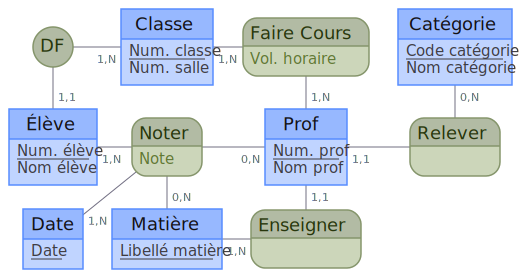

In [ ]:
%%mocodo --mld --colors ocean --shapes copperplate --relations diagram markdown_data_dict
DF, 11 Élève, 1N Classe
Classe: Num. classe, Num. salle
Faire Cours, 1N Classe, 1N Prof: Vol. horaire
Catégorie: Code catégorie, Nom catégorie

Élève: Num. élève, Nom élève
Noter, 1N Élève, 0N Prof, 0N Matière, 1N Date: Note
Prof: Num. prof, Nom prof
Relever, 0N Catégorie, 11 Prof

Date: Date
Matière: Libellé matière
Enseigner, 11 Prof, 1N Matière

L'appel ci-dessus a également construit le dictionnaire des données:

In [ ]:
# %load mocodo_notebook/sandbox_data_dict.md

- Num. classe
- Num. salle
- Vol. horaire
- Code catégorie
- Nom catégorie
- Num. élève
- Nom élève
- Note
- Num. prof
- Nom prof
- Date
- Libellé matière

Ainsi que le diagramme relationnel, qui peut être visualisé par un nouvel appel:

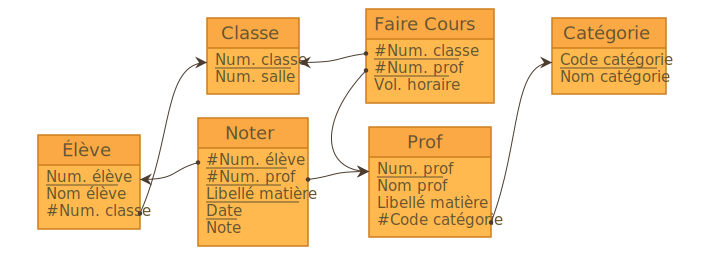

In [ ]:
%mocodo --input mocodo_notebook/sandbox.mld --colors desert

La devise de Mocodo, « nickel, ni souris », en résume les principaux points forts:

- description textuelle des données. L'utilisateur n'a pas à renseigner, placer et déplacer des éléments comme avec une lessive ordinaire. Il ne fournit rien de plus que les informations définissant son MCD. L'outil s'occupe tout seul du plongement;
- propreté du rendu. La sortie se fait en vectoriel, prête à être affichée, imprimée, agrandie, exportée dans une multitude de formats sans perte de qualité;
- rapidité des retouches. L'utilisateur rectifie les alignements en insérant des éléments invisibles, en dupliquant des coordonnées ou en ajustant des facteurs mutiplicatifs: là encore, il travaille sur une description textuelle, et non directement sur le dessin.

Mocodo est libre, gratuit et multiplateforme. Si vous l'aimez, répandez la bonne nouvelle en incluant l'un de ses logos dans votre support: cela multipliera ses chances d'attirer des contributeurs qui le feront évoluer.

# 2. Installation du programme <a id='installation_du_programme'></a>

## 2.1. Installation complète (recommandé) <a id='installation_complete_recommande'></a>

- Installez la [distribution Anaconda](http://continuum.io/downloads), qui contient Python (2 ou 3), IPython et bien plus encore.
- Tapez ensuite sous un terminal la ligne de commande:

        pip install mocodo_magic

Cette commande installera Mocodo, ainsi que l'extension IPython qui permettra de l'utiliser dans un document comme celui-ci (il s'agit d'un _Jupyter notebook_).

## 2.2. Vérification <a id='verification'></a>

Toujours sous un terminal, tapez:

    mocodo

Si votre système se plaint que cette commande n'existe pas, localisez le fichier `mocodo` et ajoutez le chemin du répertoire contenant à votre `PATH`:
- [sous Linux ou Mac OS X](http://www.commentcamarche.net/faq/3585-bash-la-variable-d-environnement-path#v-ajouter-un-repertoire-a-la-variable-path);
- [sous Windows](http://sametmax.com/ajouter-un-chemin-a-la-variable-denvironnement-path-sous-windows/).

Pour mettre la « commande magique » `mocodo` à disposition d'un _notebook_ donné, évaluez dans celui-ci la cellule suivante:

    %reload_ext mocodo_magic

Techniquement, `%load_ext mocodo_magic` suffit, mais cette forme vous épargnera un message d'erreur si vous réévaluez ultérieurement la cellule. Pour tester, évaluez une cellule avec:

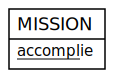

In [ ]:
%%mocodo
MISSION: accomplie

Pour charger automatiquement `mocodo_magic` à chaque ouverture d'un notebook (ce qui dispense d'évaluer `%load_ext mocodo_magic`) :

- exécuter sous un terminal :

			ipython profile create
	
- éditer le fichier créé (p. ex.: `~/.ipython/profile_default/ipython_config.py`) pour remplacer les lignes suivantes :

			## A list of dotted module names of IPython extensions to load.
			#c.InteractiveShellApp.extensions = []

  par celles-ci :

			## A list of dotted module names of IPython extensions to load.
			c.InteractiveShellApp.extensions = [
			    "mocodo_magic",
			]

## 2.3. Installation minimale <a id='installation_minimale'></a>

- Si vous êtes sous Mac OS X ou Linux, vous avez déjà Python. Dans le cas contraire, vous devrez probablement [l'installer](https://www.python.org/downloads/).
- Une fois Python installé, tapez sous un terminal:

      pip install mocodo

Vous ne bénéficierez pas de Jupyter Notebook, mais vous pourrez utiliser Mocodo en ligne de commande.

# 3. Utilisation <a id='using_mocodo'></a>

Vous pouvez utiliser Mocodo:

- dans un navigateur récent, sans rien installer, avec [Mocodo _online_](http://mocodo.net);
- sur votre machine, comme n'importe quel programme Python;
- dans un document Jupyter Notebook (à l'instar de cette documentation).

## 3.1. Utiliser Mocodo _online_ <a id='utiliser_mocodo__online_'></a>

Faites pointer votre navigateur sur http://mocodo.net: vous pouvez commencer à taper votre MCD. Appuyez à tout moment sur le bouton de génération pour visualiser le diagramme conceptuel et en déduire les relations. Une fois que le résultat vous convient, appuyez sur le bouton de téléchargement pour récupérer une archive ZIP contenant tous les fichiers d'entrée et de sortie désirés.

Mocodo _online_ est conçu pour une utilisation occasionnelle et/ou interactive, et son interface vise avant tout à la simplicité. Vous n'avez donc accès qu'aux options essentielles du programme. Si vous en voulez davantage, tant en termes de paramétrage, que de calcul ou de fonctionnalités, vous pouvez installer Mocodo sur votre machine.

## 3.2. Utiliser Mocodo en ligne de commande <a id='utiliser_mocodo_en_ligne_de_commande'></a>

### 3.2.1. Au plus simple <a id='au_plus_simple'></a>

Tout a été fait pour faciliter au maximum la prise en main. Ainsi, pour peu que vous sachiez lancer une console (`cmd` sous Windows, Terminal sous Mac OS X), il vous suffit d'y entrer:

```
mocodo
```

Invoqué sous cette forme, le script récupère le texte d'entrée du MCD dans le répertoire courant sous le nom de `sandbox.mcd`. Si ce fichier n'existe pas, il y sera automatiquement créé avec un MCD d'exemple. Par la suite, vous n'aurez qu'à le garder ouvert sous un éditeur de texte, afin de le modifier selon vos besoins avant de lancer la commande.

### 3.2.2. Liste des arguments <a id='parametrage_occasionnel'></a>

La commande `mocodo` admet de nombreux arguments optionnels. Voici la traduction en français de la liste affichée par l'argument `--help`. Destinée à servir de référence, elle peut être [sautée](#erd_description) sans inconvénient à la première lecture. Nous avons ajouté des liens vers des exemples d'utilisation dans ce document; notez cependant que les `%%` ou `%` qui préfixent la « commande magique » `mocodo` doivent être omis de la ligne de commande.

#### 3.2.2.1. Options sur Mocodo lui-même <a id='options_sur_mocodo_lui_meme'></a>

- **`--help`**.  
  Affiche un message d'aide, puis termine.
- **`--version`**.  
  Affiche le numéro de version, puis termine.
- **`--language CODE`**.  
  Outrepasse la localisation automatique des messages avec le code de langage donné (p. ex., `fr`, `en`, ...) (défaut: langue du système).
- **`--restore`**.  
  Recrée une version originelle des fichiers `sandbox.mcd` et `params.json` dans le répertoire d'entrée, puis termine (défaut: `False`).

#### 3.2.2.2. Entrée-sortie <a id='entree_sortie'></a>

- **`--params_path PATH`**.  
  Le chemin du fichier de paramètres. S'il est omis, utilise `params.json` dans le répertoire d'entrée. Si ce fichier n'existe pas, utilise les paramètres par défaut (défaut: `params.json`).
- [**`--input PATH`**](#relational_diagram).  
  Le chemin du fichier d'entrée. Les fichiers de sortie seront par défaut générés dans le même répertoire (défaut: `sandbox.mcd`). 
- **`--output_dir PATH`**.  
  Le répertoire où générer les fichiers de sortie (défaut: le répertoire où se trouve le fichier d'entrée). 
- **`--encodings [STR [STR ...]]`**.  
  Un ou plusieurs encodages à essayer successivement pour lire le fichier d'entrée (défaut: `utf8`, puis encodage historique de la plateforme).
- **`--extract`**.  
  Crée un fichier JSON séparé pour les paramètres géométriques (défaut: `False`).
- **`--image_format {svg,nodebox}`**.  
  Outrepasse la sélection automatique du format d'image produit par le script généré (défaut: dépendant de votre système et de votre installation).
- **`--print_params`**.  
  Affiche le contenu du fichier de paramètres, puis termine (défaut: `False`).

#### 3.2.2.3. Aspect de la sortie graphique <a id='aspect_de_la_sortie_graphique'></a>

- [**`--df STR`**](#df_symbol).  
  Acronyme à encercler dans une dépendance fonctionnelle (défaut: `DF`).
- [**`--card_format STR`**](#card_format).  
  Chaîne de format pour les cardinalités minimale et maximale (défaut: `{min_card},{max_card}`).
- [**`--strengthen_card STR`**](#entites_faibles).  
  Chaîne pour les cardinalités relatives (défaut: `_1,1_`).
- [**`--flex FLOAT`**](#inflexion).  
  Infléchit les pattes rectilignes dont les cardinalités sont susceptibles de collision (défaut: `0.75`).
- **`--tkinter`**.  
  Utilise Tkinter pour calculer les dimensions des libellés (défaut: `False`).
- [**`--colors PATH`**](#introduction).  
  Palette de couleurs à utiliser lors de la génération du dessin. Nom (sans extension) d'un fichier du répertoire `colors`, ou chemin vers un fichier personnel (défaut: `bw`).
- [**`--shapes PATH`**](#introduction).  
  Spécification des polices, des dimensions, etc. Nom (sans extension) d'un fichier du répertoire `shapes`, ou chemin vers un fichier personnel (défaut: dépendant de votre système).
- [**`--scale SCALE`**](#introduction).  
  Facteur d'échelle multiplicatif (défaut: `1.0`).
- **`--hide_annotations`**.  
  Ignore le survol des éléments annotés (défaut: `False`).

#### 3.2.2.4. Sortie relationnelle <a id='sortie_relationnelle'></a>

- [**`--relations [NAME [NAME ...]]`**](#external_representations).  
  Un ou plusieurs gabarits pour les schémas relationnels générés. Cf. répertoire `relation_templates` (défaut: `html text`).
- [**`--disambiguation {numbers_only,annotations}`**](#retablissement_semantique_df).  
  Méthode de désambiguïsation des attributs migrants homonymes (défaut: `annotations`).
- [**`--title STR`**](#sql_generation).  
  Nom de la base (utilisé pour la sortie SQL) (défaut: `Sans titre`).
- **`--guess_title`**.  
  Utiliser le nom de l'entité la plus référencée comme titre (défaut: `False`).

#### 3.2.2.5. Modifications du texte d'entrée <a id='modifications_du_texte_d_entree'></a>

- [**`--arrange [{bb,ga,lp}]`**](#rearrangement_automatique).  
  Met en page le diagramme, soit par séparation et évaluation, soit avec un algorithme génétique, soit avec un solveur de programmes linéaires, puis termine (défaut: `None`).
- **`--timeout SECONDS`**.  
  Limite la durée du calcul de la mise en page (défaut: `None`).
- **`--verbose`**.  
  Affiche des détails oiseux lors du réarrangement (défaut: `False`).
- [**`--flip {h,v,d}`**](#rearrangement_par_symetrie).  
  Affiche une version retournée horizontalement / verticalement / diagonalement du texte d'entrée, puis termine (défaut: `None`).
- [**`--fit [INT]`**](#reformatage_automatique).  
  Reformate le texte d'entrée dans la ième plus petite grille possible, puis termine (défaut: `None`).
- [**`--obfuscate [PATH]`**](#obfuscation).  
  Affiche une version du texte d'entrée vidée de sa sémantique, puis termine. Cf. répertoire `lorem` (défaut: `None`).
- [**`--obfuscation_max_length INT`**](#obfuscation).  
  Longueur maximale des mots de substitution (défaut: `None`).
- [**`--obfuscation_min_distance INT`**](#obfuscation).  
  Distance de Damerau Levenshtein minimale entre deux mots de substitution (défaut: 3).
- [**`--seed FLOAT`**](#non_organic).  
  Valeur du germe du générateur aléatoire (défaut: `None`).

#### 3.2.2.6. Réarrangement par séparation et évaluation <a id='rearrangement_par_separation_et_evaluation'></a>

Sous-options accessibles avec l'option `--arrange=bb`.

- **`--call_limit INT`**.  
  Nombre maximal d'appels pour une boîte de départ donnée (défaut: `10000`).
- **`--min_objective INT`**.  
  Meilleur objectif esthétique pour la mise en page (défaut: `0`).
- **`--max_objective INT`**.  
  Pire objectif esthétique pour la mise en page (défaut: `15`).
- [**`--organic`**](#organic).  
  Réarrangement non limité à la grille originelle (défaut: `False`).

#### 3.2.2.7. Réarrangement par algorithme génétique <a id='rearrangement_par_algorithme_genetique'></a>

Sous-options accessibles avec l'option `--arrange=ga`.

  - **`--population_size INT`**.  
    Nombre d'individus à faire évoluer (défaut: `1000`).
  - **`--crossover_rate RATE`**.  
    Taux de croisement, entre 0 et 1 (défaut: `0.9`).
  - **`--mutation_rate RATE`**.  
    Taux de mutation, entre 0 et 1 (défaut: `0.06`).
  - **`--sample_size INT`**.  
    Taille de l'échantillon pour les tournois (défaut: `7`).
  - **`--max_generations INT`**.  
    Nombre maximal de générations (défaut: `300`).
  - **`--plateau INT`**.  
    Nombre maximal de générations consécutives sans amélioration (défaut: `30`).

#### 3.2.2.8. Réarrangement par résolution d'un programme linéaire <a id='rearrangement_par_resolution_d_un_programme_lineaire'></a>

Sous-options accessibles avec l'option `--arrange=lp`.

  - [**`--engine [{cplex,gurobi}]`**](#methode_exacte_generique).  
    Solveur de programmes linéaires (défaut: `None`).

#### 3.2.2.9. Options spécifiques aux Notebooks <a id='options_specifiques_aux_notebooks'></a>

Ignorées lors de l'appel en ligne de commande.

  - [**`--mld`**](regular_mld_conversion).  
    Affiche le schéma relationnel en HTML dans la sortie de la cellule (défaut: `False`).
  - [**`--no_mcd`**](#retablissement_semantique_df).  
    N'affiche pas le diagramme conceptuel dans la sortie de la cellule (défaut: `False`).
  - [**`--replace`**](#option_replace).  
    Remplace le contenu de la cellule par le résultat de son évaluation (défaut: `False`).

### 3.2.3. Paramétrage à long terme <a id='parametrage_a_long_terme'></a>

Pour éviter d'avoir à invoquer Mocodo répétitivement avec une longue kyrielle d'options, vous pouvez mettre celles-ci une fois pour toutes dans un fichier `params.json` situé dans le répertoire courant. La commande:

    mocodo --restore

... le fait pour vous avec un fichier de paramètres vide, i.e. , un fichier-texte réduit aux deux caractères `{}`  (attention, elle rétablit aussi le fichier `sandbox.mcd` à son contenu par défaut). Vous êtes encouragés à modifier ce fichier de paramètres selon vos goûts et vos besoins. De la sorte, le style de vos MCD pourra être maintenu à moindre frais à travers tous vos documents. En cas de besoin, vous pourrez toujours ponctuellement passer outre ces réglages en en précisant d'autres en ligne de commande. Plus précisément, chaque paramètre est déterminé:

1. par sa valuation en ligne de commande;
2. à défaut, par sa valuation dans le fichier de paramètres indiqué par `--params_path`;
3. à défaut d'une telle indication, par sa valuation dans le fichier `params.json` du répertoire courant;
4. à défaut, par une valeur défaut éventuellement dépendante de votre système.

Si vous lancez Mocodo avec l'option `--print_params`, la valeur courante de l'ensemble des paramètres sera affichée. Vous pouvez envoyer la sortie dans un fichier `params.json` et la modifier à votre gré pour une prise en compte lors du lancement suivant.

## 3.3. Utiliser Mocodo sous Jupyter Notebook <a id='ipynb_usage'></a>

### 3.3.1. Invocation <a id='invocation'></a>

Elle nécessite l'installation de l'extension notebook `mocodo`, laquelle doit en outre être rechargée à chaque ouverture (cf. première cellule de ce document). On a ainsi déclaré une « commande magique » `mocodo` qui sera invoquée en la préfixant:

- de `%%` pour prendre toutes les lignes suivantes de la cellule comme texte d'entrée du MCD;
- de `%` si l'on récupère l'entrée ailleurs (avec `--input`), ou qu'on n'en a pas besoin (p. ex., `--help` ou `--print_params`).

À part ça, la syntaxe est généralement la même qu'en ligne de commande, ce qui devrait faciliter le passage de l'un à l'autre.

### 3.3.2. Principes de fonctionnement <a id='principes_de_fonctionnement'></a>

Il peut être utile de comprendre ce qui se passe en coulisses lorsque l'on invoque la commande magique sur une cellule:

- dans le répertoire courant est créé au besoin un sous-répertoire `mocodo_notebook`;
- le texte d'entrée y est sauvegardé sous le nom de `sandbox.mcd`;
- la commande est lancée sur ce fichier avec tous les paramètres donnés par l'utilisateur. Cela signifie que tous les fichiers générés le seront au même endroit sous les noms de `sandbox.svg`, `sandbox.html`, etc.;
- si la commande a produit un dessin, celui-ci est affiché en sortie (sauf avec l'option `--no_mcd`); avec l'option `--mld`, le schéma relationnel est également affiché au-dessous (au format HTML);
- si elle n'a pas produit de dessin, mais une nouvelle version du texte d'entrée (options `--arrange`, `--flip`, `--obfuscate`, ...), Mocodo est automatiquement relancé sur celle-ci, permettant de visualiser le diagramme et/ou le schéma relationnel correspondants.

Tous les fichiers peuvent être lus dans le répertoire `mocodo_notebook` (commande magique `%load`, mise en commentaire dans ce notebook pour éviter de recharger le fichier à chaque exécution).

### 3.3.3. Exemples d'invocation <a id='exemples_d_invocation'></a>

Les trois exemples de l'[introduction](#introduction) illustrent plusieurs de ces techniques usuelles:

    %%mocodo --mld --colors ocean --shapes copperplate --relations diagram markdown_data_dict

... invoque le programme en demandant l'affichage du diagramme conceptuel (implicitement), du schéma relationnel (avec `--mld`), des changements de style (avec `--colors` et `--shapes`) et la production d'un diagramme relationnel (`--relations diagram`) et d'un dictionnaire de données (`markdown_data_dict`). Le contenu de celui-ci est rechargé et visualisé à l'aide de la commande suivante:

    %load mocodo_notebook/sandbox_data_dict.md

Tandis que le diagramme relationnel (MLD) est tracé en relançant Mocodo dessus:

    %mocodo --input mocodo_notebook/sandbox.mld --colors desert

### 3.3.4. Modification _in situ_ d'une cellule <a id='modification__in_situ__d_une_cellule'></a>

**Nouveauté de la version 2.0.20 (contribution de Thomas Giro).** Avec les options `--arrange`, `--flip` et `--obfuscate` le résultat de l'évaluation de la cellule est un nouveau MCD, normalement affiché au-dessous. Ajoutez l'option `--replace` pour substituer ce MCD au contenu de la cellule. Réévaluez alors celle-ci pour tracer le MCD résultant, ou annulez la dernière opération pour revenir au contenu originel.

Par exemple, l'évaluation de la cellule suivante:

In [ ]:
%%mocodo --flip=v --replace
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

... remplacerait celle-ci par celle-là:

In [ ]:
%%mocodo
PRODUIT: Réf. produit, Libellé, Prix unitaire
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
COMMANDE: Num commande, Date, Montant
PASSER, 0N CLIENT, 11 COMMANDE
CLIENT: Réf. client, Nom, Prénom, Adresse

### 3.3.5. Paramétrage à long terme <a id='magic_long_term_settings'></a>

Si vous voulez éviter de préciser à chaque fois les mêmes arguments (par exemple un changement de couleurs), vous pouvez placer un fichier `params.json` dans le répertoire `mocodo_notebook`. Mocodo peut même vous aider à le faire en exécutant la cellule suivante:

In [ ]:
%mocodo --print_params

Son évaluation remplace son propre contenu par des lignes de code similaires à: 

In [ ]:
# You may edit and run the following lines
import codecs, json
params = u"""
{
  "arrange": null, 
  "call_limit": 10000, 
  "colors": "bw", 
  "crossover_rate": 0.9, 
  "df": "DF", 
  "disambiguation": "annotations", 
  "encodings": [
    "utf8", 
    "macroman"
  ], 
  "extract": false, 
  "flip": null, 
  "guess_title": false, 
  "hide_annotations": false, 
  "image_format": "svg", 
  "input": "mocodo_notebook/sandbox.mcd", 
  "language": "fr", 
  "max_generations": 300, 
  "max_objective": 15, 
  "min_objective": 0, 
  "mld": false, 
  "mutation_rate": 0.06, 
  "no_mcd": false, 
  "obfuscate": null, 
  "obfuscation_max_length": null, 
  "organic": false, 
  "output_dir": "mocodo_notebook", 
  "plateau": 30, 
  "population_size": 1000, 
  "print_params": false, 
  "relations": [
    "html", 
    "text"
  ], 
  "replace": false, 
  "restore": false, 
  "sample_size": 7, 
  "scale": 1.0, 
  "seed": null, 
  "sep": ",", 
  "shapes": "copperplate", 
  "timeout": null, 
  "title": "Sans titre", 
  "tkinter": false, 
  "verbose": false
}
"""
try:
    json.loads(params)
except:
    raise RuntimeError("Invalid JSON. Find out why on http://jsonlint.com")
with codecs.open("mocodo_notebook/params.json", "w", "utf8") as f:
    f.write(params.strip())

Modifiez la variable `params` à votre gré en respectant la syntaxe [JSON](http://json.org) (attention en particulier au dernier couple clef-valeur, qui n'est pas terminé par une virgule). Exécutez la cellule pour créer un fichier de nom et emplacement adéquats (notez que la valeur de `--print_params` a été passée à `false` pour vous éviter de le faire à la main).

# 4. Description d'un MCD <a id='erd_description'></a>

## 4.1. Besoins élémentaires <a id='elementary_needs'></a>

### 4.1.1. Entités, associations, attributs, identifiants, cardinalités <a id='elements'></a>

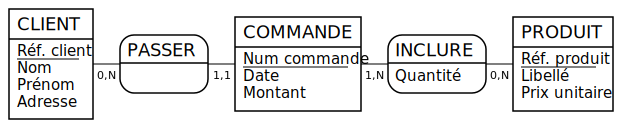

In [ ]:
%%mocodo
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

La syntaxe ne devrait pas poser problème:
- une entité est définie par son nom, deux-points, sa liste d'attributs séparés par des virgules;
- une association est définie par son nom, virgule, les cardinalités et l'entité de sa première patte, virgule, les cardinalités et l'entité de sa deuxième patte, etc., deux-points, sa liste d'attributs séparés par des virgules.

À noter :
- le premier attribut d'une entité est considéré par défaut comme son identifiant, et donc souligné;
- pour les associations sans attributs, le deux-points est facultatif;
- la première ligne:
        %%mocodo
  ... ne fait pas partie de la description. Dans ce document, elle permet de faire appel à une « commande magique », qui lance Mocodo sur les lignes qui la suivent. Sauf sous Jupyter Notebook, vous pouvez l'omettre dans votre texte d'entrée.  
  De façon générale, la ou les premières lignes d'un MCD qui commencent par le symbole de pourcentage (`%`) sont ignorées. Cela permet de placer en en-tête un commentaire qui pourra être préservé lors des éventuels réarrangements ultérieurs.
- Les accents présents dans votre fichier d'entrée sont correctement gérés pourvu que vous ayez enregistré celui-ci dans l'encodage attendu par Mocodo en entrée: c'est par défaut Unicode UTF-8. Une tolérance existe: si Mocodo échoue à décoder votre fichier avec `utf8`, il se rabattra sur le codec d'Europe de l'Ouest associé historiquement à votre plateforme: `iso-8859-15` pour Windows et Linux, `mac-roman` pour Mac OS X. Si les accents n'apparaissent pas correctement, vous aurez encore trois solutions:
  1. soit (fortement conseillé), ré-enregistrer votre fichier en UTF-8 au lieu d'un encodage historique;
  3. soit (ponctuellement), passer l'encodage de votre fichier en argument avec `--encodings`;
  2. soit (à long terme), modifier dans `params.json` la liste des encodages pris en charge.

### 4.1.2. Dépendances fonctionnelles <a id='functional_dependencies'></a>

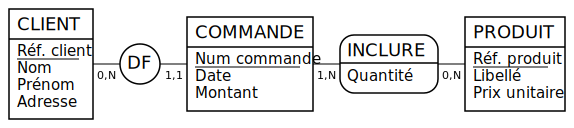

In [ ]:
%%mocodo
CLIENT: Réf. client, Nom, Prénom, Adresse
DF, 0N CLIENT, 11 COMMANDE
COMMANDE: Num commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

Si on a plusieurs dépendances fonctionnelles à représenter, on devra suffixer le DF par un numéro (cf. [cet exemple](#box_duplication)).

### 4.1.3. Associations réflexives <a id='reflexives_associations'></a>

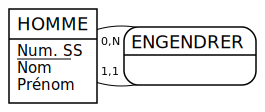

In [ ]:
%%mocodo
HOMME: Num. SS, Nom, Prénom
ENGENDRER, 0N HOMME, 11 HOMME

### 4.1.4. Placement sur plusieurs rangées <a id='placement_sur_plusieurs_rangees'></a>

L'ordre et la séparation des lignes de la description permet de spécifier à coût zéro un plongement grossier, mais qui s'avère en général suffisant:

- les boîtes (entités et associations) définies sur des lignes consécutives sont tracées sur une même rangée;
- un saut de ligne indique une nouvelle rangée.

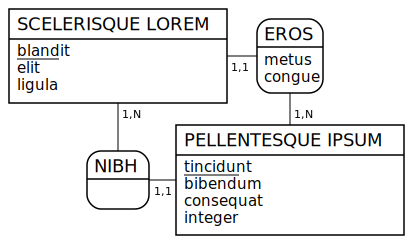

In [ ]:
%%mocodo
SCELERISQUE LOREM: blandit, elit, ligula
EROS, 11 SCELERISQUE LOREM, 1N PELLENTESQUE IPSUM: metus, congue

NIBH, 1N SCELERISQUE LOREM, 11 PELLENTESQUE IPSUM
PELLENTESQUE IPSUM: tincidunt, bibendum, consequat, integer

Les boîtes sont placées aux intersections d'une grille invisible assurant que leurs centres soient alignés aussi bien horizontalement que verticalement. C'est ce qui en général est le plus satisfaisant esthétiquement, mais d'autres retouches peuvent être opérées manuellement dans le fichier de sortie.

Le plongement fait l'objet d'une « compression » horizontale et verticale. Par exemple, ci-dessus, il y a un espace horizontal négatif entre le bord droit de l'entité de gauche et le bord gauche de l'entité de droite.

## 4.2. Besoins plus avancés <a id='besoins_plus_avances'></a>

### 4.2.1. Identifiants multiples <a id='identifiants_multiples'></a>

Préfixer d'un caractère de soulignement (`_`) le(s) second, troisième, etc. attributs pour les ajouter à l'identifiant.

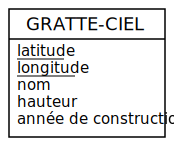

In [ ]:
%%mocodo
GRATTE-CIEL: latitude, _longitude, nom, hauteur, année de construction

### 4.2.2. Entités faibles (identification relative) <a id='entites_faibles'></a>

Préfixer d'un caractère de soulignement (`_`) une cardinalité (1,1) pour indiquer que l'entité distinguée est faible. Dans le diagramme, les identifiants (ou discriminants) d'une telle entité seront soulignés en pointillés, tandis que le (1,1) sera souligné d'un trait plein.

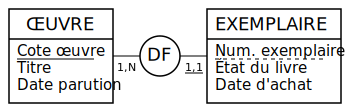

In [ ]:
%%mocodo
ŒUVRE: Cote œuvre, Titre, Date parution
DF, 1N ŒUVRE, _11 EXEMPLAIRE
EXEMPLAIRE: Num. exemplaire, État du livre, Date d'achat

**Nouveauté de la version 2.1.** Traditionnellement, l'identification relative est dénotée par des parenthèses autour des cardinalités. Cette notation (ou toute autre) peut maintenant être obtenue avec l'option `--strenghten_card`:

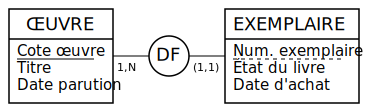

In [ ]:
%%mocodo --strengthen_card (1,1)
ŒUVRE: Cote œuvre, Titre, Date parution
DF, 1N ŒUVRE, _11 EXEMPLAIRE
EXEMPLAIRE: Num. exemplaire, État du livre, Date d'achat

Une association ne peut renforcer plus d'une entité faible. Ainsi, une erreur se produit si l'on remplace le `1N` par `_11`:

In [ ]:
%%mocodo
ŒUVRE: Cote œuvre, Titre, Date parution
DF, _11 ŒUVRE, _11 EXEMPLAIRE
EXEMPLAIRE: Num. exemplaire, État du livre, Date d'achat

ERROR: Mocodo Err.22 - Identification relative réciproque autour de DF.


### 4.2.3. Flèches sur les pattes <a id='fleches_sur_les_pattes'></a>

Suffixer d'un chevron (`<` ou `>`) les cardinalités de la patte concernée. La direction indiquée se lit en partant de l'association et en allant vers l'entité.

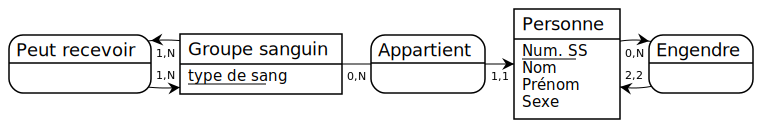

In [ ]:
%%mocodo
Peut recevoir, 1N> Groupe sanguin, 1N< Groupe sanguin
Groupe sanguin: type de sang
Appartient, 11> Personne, 0N Groupe sanguin
Personne: Num. SS, Nom, Prénom, Sexe
Engendre, 0N< Personne, 22> Personne

La position de la flèche sur la patte peut être réglée individuellement dans la table d'association `ratio` du script Python généré (par défaut, `sandbox_svg.py` ou `sandbox_nodebox.py`) ou sous l'onglet _Retouches_ de la version en ligne. La valeur correspondante peut varier de `0.0` (flèche cachée sous la boîte d'origine) à `1.0` (par défaut, pointe de la flèche au contact du bord de la boîte de destination, compte non tenu de l'arrondi s'il s'agit d'une association).

### 4.2.4. Styles <a id='styles'></a>

Plusieurs styles prédéfinis sont distribués avec l'application. Un style se définit comme la combinaison d'une palette de couleurs (répertoire `colors`) avec un dictionnaire de polices et de dimensions (répertoire `shapes`). Une changement d'échelle d'un facteur multiplicatif positif peut être précisé avec l'argument `--scale`.

Vous pouvez bien sûr créer vos propres styles en vous inspirant des fichiers fournis. Si vous êtes particulièrement content d'un style, soumettez-le pour inclusion dans une prochaine distribution.

### 4.2.5. Types de données <a id='types_de_donnees'></a>

Chaque attribut peut être assorti d'annotations entre crochets. Ignorées au niveau du tracé du MCD, elles sont [interprétées comme des types de données lors de la génération d'un code-source SQL](#sql_generation).

### 4.2.6. Format des cardinalités <a id='card_format'></a>

Par défaut, les cardinalités sont séparées par une virgule.

**Nouveauté de la version 2.1.** On peut maintenant opter pour un format quelconque:

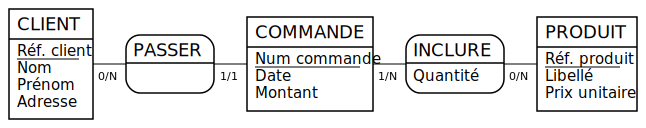

In [ ]:
%%mocodo --card_format={min_card}/{max_card}
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

### 4.2.7. Rectification automatique des cardinalités mal formées <a id='rectification_automatique_des_cardinalites_mal_formees'></a>

Certaines fautes de frappe fréquentes (inversion des cardinalités minimale et maximale, lettre « O » au lieu du chiffre « 0 ») sont silencieusement rectifiées:

| formes erronées | forme rectifiée |
|-----------------|-----------------|
| `O1`, `o1`, `10`, `1O`, `1o` | `01` |
| `ON`, `oN`, `NO`, `No`, `N0` | `0N` |
| `On`, `on`, `no`, `nO`, `n0` | `0n`|
| `N1` | `1N` |
| `n1` | `1n` |

Les cardinalités (N,N), qui selon une certaine école dénotent une cardinalité minimale supérieure à 1, sont laissées telles quelles.

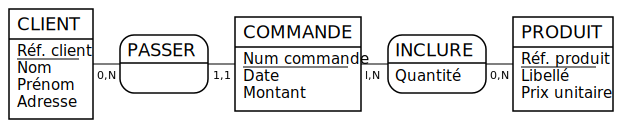

In [ ]:
%%mocodo
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, oN CLIENT, 11 COMMANDE
COMMANDE: Num commande, Date, Montant
INCLURE, lN COMMANDE, ON PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

### 4.2.8. Symbole de dépendance fonctionnelle <a id='df_symbol'></a>

Il est possible d'activer l'encerclement d'un autre sigle que DF. C'est ce sigle qui devra alors apparaître en entrée, par exemple:

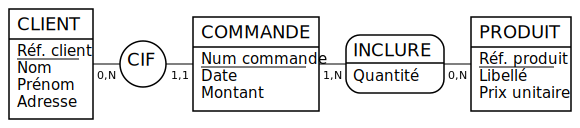

In [ ]:
%%mocodo --df=CIF
CLIENT: Réf. client, Nom, Prénom, Adresse
CIF, 0N CLIENT, 11 COMMANDE
COMMANDE: Num commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

Comme le cercle est alors un peu plus grand, on peut vouloir régler (_a priori_ une fois pour toutes) le ratio défini dans le dictionnaire de `shapes`:

```
"df_text_height_ratio"             : 1.00,
```

### 4.2.9. Créer plusieurs entités ou associations de même nom <a id='box_duplication'></a>

Normalement on doit choisir des noms différents pour toutes les boîtes (entités et associations) du MCD, à l'exception des associations de dépendance fonctionnelle figurées par un sigle. On a vu que dans ce cas, il suffisait d'ajouter à leur nom un suffixe numérique: celui-ci n'apparaîtra pas en sortie. Cette possibilité vaut pour n'importe quelle boîte.

Elle servira typiquement à « distribuer » une entité DATE réduite à son identifiant _date_, mais associée à de nombreuses entités qui n'ont rien à voir entre elles. Sachant qu'une telle entité est amenée à disparaître lors du passage au relationnel, il n'y a aucun inconvénient à en créer plusieurs, et cela peut avoir l'avantage de faciliter (ou même de rendre possible) l'obtention d'une bonne mise en page.

Par exemple, la mise en page du MCD suivant est indûment complexifiée par le haut degré de l'entité DATE.

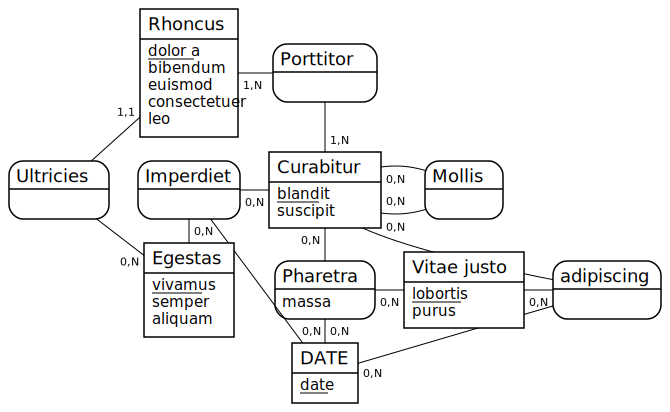

In [ ]:
%%mocodo
:
Rhoncus: dolor a, bibendum, euismod, consectetuer, leo
Porttitor, 1N Rhoncus, 1N Curabitur
:
:

Ultricies, 11 Rhoncus, 0N Egestas
Imperdiet, 0N Egestas, 0N Curabitur, 0N DATE
Curabitur: blandit, suscipit
Mollis, 0N Curabitur, 0N Curabitur
:

:
Egestas: vivamus, semper, aliquam
Pharetra, 0N Curabitur, 0N DATE, 0N Vitae justo: massa
Vitae justo: lobortis, purus
adipiscing, 0N Curabitur, 0N Vitae justo, 0N DATE

:
:
DATE: date
:
:

Ajouter une autre entité DATE (sous le nom de DATE2) permettra à Mocodo de calculer une mise en page à la fois plus agréable à l'œil et plus compacte ($4\times3$ au lieu de $5\times4$). La sémantique est inchangée.

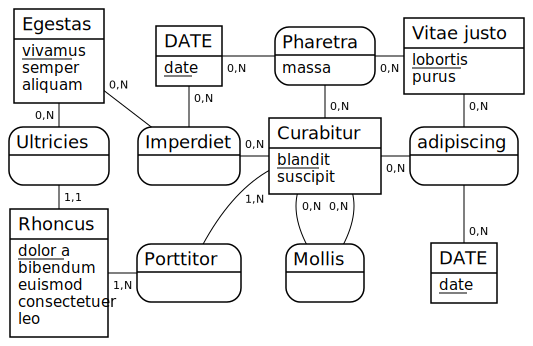

In [ ]:
%%mocodo
Egestas: vivamus, semper, aliquam
DATE: date
Pharetra, 0N Curabitur, 0N DATE, 0N Vitae justo: massa
Vitae justo: lobortis, purus

Ultricies, 11 Rhoncus, 0N Egestas
Imperdiet, 0N Egestas, 0N Curabitur, 0N DATE
Curabitur: blandit, suscipit
adipiscing, 0N Curabitur, 0N Vitae justo, 0N DATE2

Rhoncus: dolor a, bibendum, euismod, consectetuer, leo
Porttitor, 1N Rhoncus, 1N Curabitur
Mollis, 0N Curabitur, 0N Curabitur
DATE2: date

## 4.3. Besoins spécifiques à la pédagogie <a id='besoins_specifiques_a_la_pedagogie'></a>

Si vous n'êtes pas enseignant de bases de données, vous pouvez [passer directement à la section suivante](#MCD_drawing).

### 4.3.1. Créer une vue en extension <a id='creer_une_vue_en_extension'></a>

La [technique de duplication](#box_duplication) que l'on vient de voir peut servir à produire une vue en extension d'un MCD. Voici par exemple le MCD que j'utilise en cours pour introduire la notion d'entité faible (à gauche, vue en compréhension, à droite vue en extension):

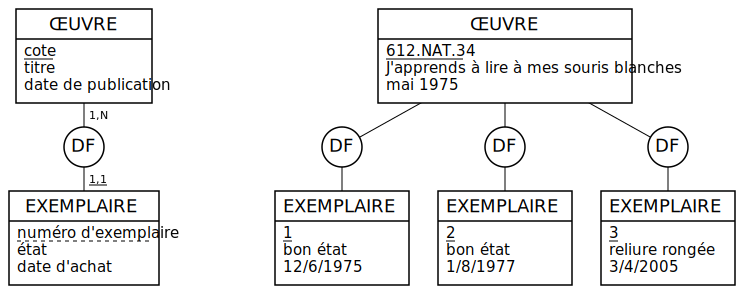

In [ ]:
%%mocodo
ŒUVRE1: cote, titre, date de publication
::::
ŒUVRE2: 612.NAT.34, J'apprends à lire à mes souris blanches, mai 1975
:
    
DF1, 1N ŒUVRE1, _11 EXEMPLAIRE1
:::
DF2, XX ŒUVRE2, XX EXEMPLAIRE2
DF3, XX ŒUVRE2, XX EXEMPLAIRE3
DF4, XX ŒUVRE2, XX EXEMPLAIRE4

EXEMPLAIRE1: numéro d'exemplaire, état, date d'achat
:::
EXEMPLAIRE2: 1, bon état, 12/6/1975
EXEMPLAIRE3: 2, bon état, 1/8/1977
EXEMPLAIRE4: 3, reliure rongée, 3/4/2005

### 4.3.2. Afficher l'explication des cardinalités <a id='leg_annotation_description'></a>

Les débutants ont souvent des doutes sur la sémantique de telle ou telle cardinalité. Cette information peut désormais être incluse dans le texte-source, en annotant les pattes correspondantes, pour apparaître à la demande lors du rendu (utile pour créer des exercices à faire en TD ou en autonomie).

Survolez les cardinalités du MCD ci-dessous pour faire apparaître leur description.

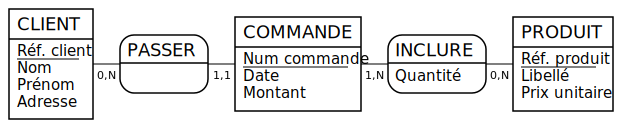

In [ ]:
%%mocodo
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N [Un client peut passer un nombre quelconque de commandes.] CLIENT, 11 [Toute commande est passée par un en un seul client.] COMMANDE
COMMANDE: Num commande, Date, Montant
INCLURE, 1N [Une commande peut inclure plusieurs produits distincts, et en inclut au moins un.] COMMANDE, 0N [Certains produits ne sont jamais commandés, d'autres le sont plusieurs fois.] PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

Les annotations s'insèrent entre cardinalités et nom de l'entité. Elles sont délimitées par des crochets droits.

Avec l'option `--disambiguation=annotations` (par défaut), elles sont également exploitables lors du passage au relationnel pour [préciser la sémantique d'une clef étrangère](#retablissement_semantique_df).

L'affichage est désactivé avec l'option `--hide_annotations`.

**Limitations.**

- Ne fonctionne pas sous Inkscape.
- Ne semble pas fonctionner dans une page HTML statique (comme la version HTML de ce document sous GitHub).
- Semble nécessiter une réévaluation de la cellule pour fonctionner dans un notebook fermé, puis rouvert.
- Sans effet sur le diagramme conceptuel généré avec l'option `--image_format=nodebox`.

### 4.3.3. Créer un MCD à compléter <a id='creer_un_mcd_a_completer'></a>

Les MCD à trous sont des exercices classiques d'introduction aux bases de données.

#### 4.3.3.1. Supprimer le marquage d'un identifiant <a id='supprimer_le_marquage_d_un_identifiant'></a>

Pour éviter le marquage automatique du premier attribut d'une entité comme identifiant, il suffit de le préfixer par un `_` (ce caractère est donc un commutateur, qui souligne un attribut non souligné par défaut, et désouligne un attribut souligné par défaut).

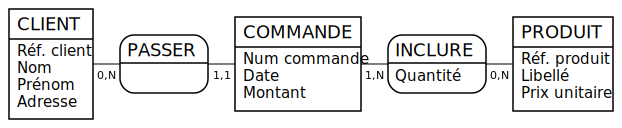

In [ ]:
%%mocodo
CLIENT: _Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: _Num commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: _Réf. produit, Libellé, Prix unitaire

#### 4.3.3.2. Masquer un couple de cardinalités <a id='masquer_un_couple_de_cardinalites'></a>

Vous pouvez masquer n'importe quelles cardinalités en les remplaçant pas `XX` (ci-dessous à gauche) :

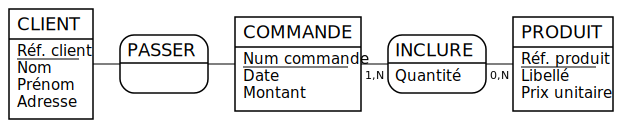

In [ ]:
%%mocodo
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, XX CLIENT, XX COMMANDE
COMMANDE: Num commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

#### 4.3.3.3. Masquer un attribut <a id='masquer_un_attribut'></a>

Vous pouvez mettre deux virgules consécutives pour réserver la place d'un attribut manquant.

Les espaces insécables sont préservés, ce qui permet de réserver plus d'espace horizontal, cf. ci-dessous premier attribut vide de INCLURE.

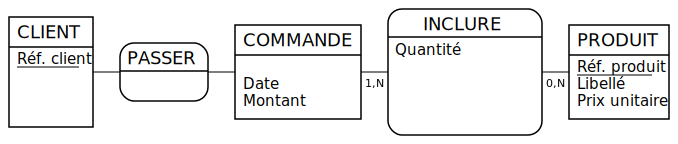

In [ ]:
%%mocodo
CLIENT: Réf. client, , , 
PASSER, XX CLIENT, XX COMMANDE
COMMANDE: , Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité,                    , , ,
PRODUIT: Réf. produit, Libellé, Prix unitaire

#### 4.3.3.4. Ne faire apparaître que le squelette du schéma conceptuel <a id='mcd_skeleton'></a>

Enfin, vous pouvez transformer en exercice à trous n'importe quel MCD en rendant complètement transparentes les couleurs des attributs, associations et cardinalités. Le style `blank` a été prédéfini à cet effet:

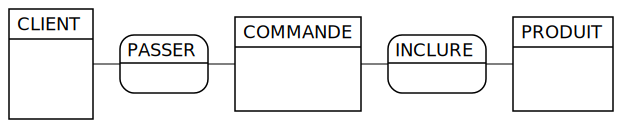

In [ ]:
%%mocodo --colors=blank
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

Attention, n'utilisez pas cette méthode si vous souhaitez diffuser l'exercice sous forme électronique: l'information textuelle est toujours présente, susceptible d'être sélectionnée et collée ailleurs pour être lue. Vous pouvez bien sûr empêcher cette possibilité en convertissant la figure dans un format bitmap (comme PNG ou GIF); mais le plus simple est de combiner les deux méthodes précédentes:

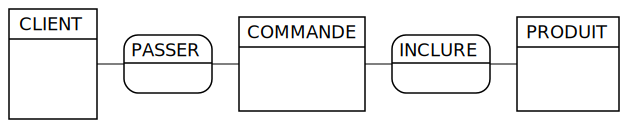

In [ ]:
%%mocodo
CLIENT: ,          ,,
PASSER, XX CLIENT, XX COMMANDE
COMMANDE: ,               ,
INCLURE, XX COMMANDE, XX PRODUIT: 
PRODUIT: ,            ,

### 4.3.4. Obfuscation: remplacer tous les libellés par du faux-texte <a id='obfuscation'></a>

L'obfuscation d'un MCD consiste à vider celui-ci de sa sémantique de surface, en substituant à tous les libellés des chaînes aléatoires. Le résultat sera par exemple utilisé pour montrer que les principales règles de passage du schéma conceptuel au schéma relationnel peuvent être appliquées « bêtement », c'est-à-dire sans comprendre le fonctionnement de l'organisme modélisé.

Ainsi, dans l'exemple ci-dessous, les libellés du MCD _CLIENT-COMMANDE-PRODUIT_ sont remplacés par des mots tirés au hasard:

%%mocodo
MAURIS: Cubilia, Tortor, Maecenas, Tempor erat
AMET PROIN, 0N MAURIS, 11 EUISMOD
EUISMOD: Placerat, Cras sem, Pede blandit
EGESTAS, 1N EUISMOD, 0N TINCIDUNT: Imperdiet
TINCIDUNT: Quam tempus, Lacus, Iaculis


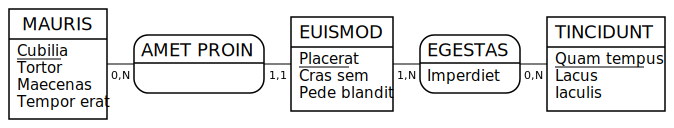

In [ ]:
%%mocodo --obfuscate
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

**Nouveauté de la version 2.0.20.** Pour remplacer le texte de la cellule par le résultat de son évaluation, ajoutez l'[option `--replace`](#option_replace).

En argument, vous pouvez ajouter le chemin d'un fichier texte UTF-8 quelconque où puiser les mots de substitution. Par exemple, le texte même de cette documentation:

In [ ]:
%%mocodo --obfuscate=fr_refman.ipynb --obfuscation_max_length=10 --seed=5 --no_mcd
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

%%mocodo
HORIZONTAL: Date, Euismod, Devraient, Associé
SUR, 0N HORIZONTAL, 11 BEFORE
BEFORE: _l on, Matière w, Étapes
PERDANT, 1N BEFORE, 0N PROPOSER: Posuere de
PROPOSER: Grille, Insécables, Bien emph


Mocodo essaie d'abord de trouver ce fichier à l'endroit indiqué. En cas d'échec, il le cherche (avec extension `.txt` facultative) parmi les textes distribués avec le logiciel, à savoir:

- `"lorem_ipsum.txt"`: le [faux-texte](https://fr.wikipedia.org/wiki/Faux-texte) le plus courant.
- `"disparition.txt"`: le lexique du [célèbre roman lipogrammatique](https://fr.wikipedia.org/wiki/La_Disparition_&#40;roman&#41;) de Georges Perec.
- `"four_letter_words.txt"`: une sélection (SFW) de mots anglais de quatre lettres.

En cas de nouvel échec, il se rabat sur `"lorem_ipsum.txt"`.

L'option `obfuscation_max_length` permet de limiter la longueur des libellés de substitution (par défaut, c'est la longueur du plus long mot du faux-texte).

Notez enfin que l'algorithme s'assure que la [distance de Damerau-Levenshtein](https://fr.wikipedia.org/wiki/Distance_de_Damerau-Levenshtein) entre deux libellés de substitution quelconques est d'au moins 3 (valeur par défaut du paramètre `obfuscation_min_distance`). En clair, cela signifie que, si vous donnez en examen un exercice de conversion en relationnel basé sur un tel MCD, les erreurs de transcription d'un étudiant stressé, inattentif, illettré, dyslexique, roublard, ou tout cela à la fois, ne vous empêcheront pas de retrouver son intention première. Par exemple, au cours du processus d'obfuscation suivant:

In [ ]:
%%mocodo --obfuscate=four_letter_words --seed=42 --no_mcd
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

%%mocodo
ITEM: Norm, Wash, Haul, Milk
DRAW, 0N ITEM, 11 LADY
LADY: Face, Soon, Ever
UNIT, 1N LADY, 0N TOUR: Fold
TOUR: Bind, Gene, Aids


L'algorithme a écarté les mots _dish_ (confusion possible avec _wash_), _folk_ (confusion possible avec _milk_), _peer_ (confusion possible avec _ever_), _hall_ (confusion possible avec _haul_), _baby_ (confusion possible avec _lady_).

# 5. Tracé d'un MCD <a id='MCD_drawing'></a>

## 5.1. Insertion manuelle d'espacements <a id='insertion_manuelle_d_espacements'></a>

Le tracé réalisé par Mocodo pour des MCD de plusieurs rangées laisse parfois à désirer :

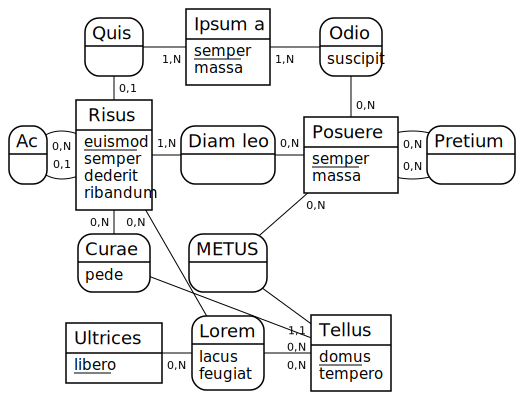

In [ ]:
%%mocodo
Quis, 01 Risus, 1N Ipsum a
Ipsum a: semper, massa
Odio, 1N Ipsum a, 0N Posuere: suscipit

Ac, 01 Risus, 0N Risus
Risus: euismod, semper, dederit, ribandum
Diam leo, 1N Risus, 0N Posuere
Posuere: semper, massa
Pretium, 0N Posuere, 0N Posuere

Curae, 0N Risus, 0N Tellus: pede
METUS, 11 Tellus, 0N Posuere

Ultrices: libero
Lorem, 0N Ultrices, 0N Tellus, 0N Risus: lacus, feugiat
Tellus: domus, tempero

On voit que, par défaut, Mocodo centre les rangées qui contiennent moins de boîtes que les autres. Cela donne un bon résultat pour la première rangée, mais pas pour la troisième.

L'utilisateur peut cependant spécifier les espacements qu'il désire en complétant les rangées les moins fournies, par des boîtes invisibles dont le seul rôle est de « pousser » les autres à l'emplacement voulu. Ainsi, il va préciser que l'association _Curae_ doit commencer sur la troisième colonne en insérant des lignes réduites au caractère deux-points, et en profiter pour insérer un espace entre _Lorem_ et _Tellus_ :

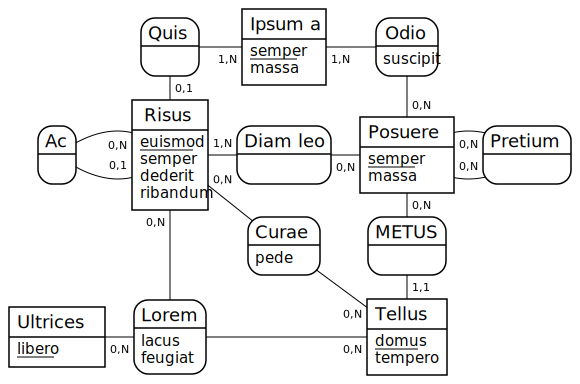

In [ ]:
%%mocodo
Quis, 01 Risus, 1N Ipsum a
Ipsum a: semper, massa
Odio, 1N Ipsum a, 0N Posuere: suscipit

Ac, 01 Risus, 0N Risus
Risus: euismod, semper, dederit, ribandum
Diam leo, 1N Risus, 0N Posuere
Posuere: semper, massa
Pretium, 0N Posuere, 0N Posuere

:
:
Curae, 0N Risus, 0N Tellus: pede
METUS, 11 Tellus, 0N Posuere
:

Ultrices: libero
Lorem, 0N Ultrices, 0N Tellus, 0N Risus: lacus, feugiat
:
Tellus: domus, tempero

Il est possible de « compresser » les suites de deux-points en supprimant les retours-chariots, autrement dit, de remplacer $n$ lignes réduites à deux-points par une ligne réduite à une séquence de $n$ deux-points. Ce raccourci est illustré dans le prochain exemple.

## 5.2. Ajustement automatique dans une grille minimale <a id='reformatage_automatique'></a>

**Nouveauté de la version 2.2.** On cherche en général à faire tenir le MCD dans la plus petite grille possible, tout en maintenant un rapport « équilibré » entre hauteur et largeur. Par exemple, un MCD de 13 boîtes (entités ou associations) peut tenir dans les grilles:

- $13\times1$;
- $7\times2$, ce qui laisse 1 case vide;
- $5\times3$, ce qui laisse 2 cases vides;
- $4\times4$, ce qui laisse 3 cases vides;
- etc.

Les deux premières grilles étant non équilibrées, on retiendra la plus petite des suivantes, de dimensions $5\times3$.

La table ci-dessous énumère les dimensions des grilles minimales d'équilibre supérieur à 0,5 pour tous les MCD comportant moins de 100 boîtes:

|  | **1** | **2** | **3** | **4** | **5** | **6** | **7** | **8** | **9** | **10** | **11** | **12** | **13** |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| **1** | 1 |  |  |  |  |  |  |  |  |  |  |  |  |
| **2** |  | 2, 3, 4 | 5, 6 |  |  |  |  |  |  |  |  |  |  |
| **3** |  |  | 7, 8, 9 | 10, 11, 12 | **13**, 14, 15 |  |  |  |  |  |  |  |  |
| **4** |  |  |  | 16 | 17, 18, 19, 20 | 21, 22, 23, 24 | 26, 27, 28 |  |  |  |  |  |  |
| **5** |  |  |  |  | 25 | 29, 30 | 31, 32, 33, 34, 35 | 37, 38, 39, 40 | 43, 44, 45 |  |  |  |  |
| **6** |  |  |  |  |  | 36 | 41, 42 | 46, 47, 48 | 50, 51, 52, 53, 54 | 57, 58, 59, 60 | 65, 66 |  |  |
| **7** |  |  |  |  |  |  | 49 | 55, 56 | 61, 62, 63 | 67, 68, 69, 70 | 73, 74, 75, 76, 77 | 82, 83, 84 | 91 |
| **8** |  |  |  |  |  |  |  | 64 | 71, 72 | 78, 79, 80 | 85, 86, 87, 88 | 92, 93, 94, 95, 96 |  |
| **9** |  |  |  |  |  |  |  |  | 81 | 89, 90 | 97, 98, 99 |  |  |

On peut y vérifier par exemple que le MCD de taille 13 se trouve effectivement aux coordonnées (5, 3).

Avec l'option `--fit`, Mocodo est maintenant capable de reformater automatiquement un MCD pour le faire entrer dans la grille minimale correspondante:

In [ ]:
%%mocodo --fit
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh
    
Bibendum, 01 Blandit, 0N Blandit
Blandit: consequat, ligula, nibh, consequat
Ipsum, 1N Blandit, 0N Congue

Congue: ligula, tellus
Augue, 0N Congue, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
    
DF, 11 Nonummy, 0N Congue
Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
    
Nonummy: consequat, ligula

%%mocodo
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh
Bibendum, 01 Blandit, 0N Blandit
Blandit: consequat, ligula, nibh, consequat

Ipsum, 1N Blandit, 0N Congue
Congue: ligula, tellus
Augue, 0N Congue, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
DF, 11 Nonummy, 0N Congue

Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
Nonummy: consequat, ligula
::


L'algorithme se contente de supprimer ou d'insérer des sauts de ligne dans le texte-source, sans modifier l'ordre des clauses. On devra donc encore en général opérer sur le résultat un réarrangement automatique ([voir plus loin](#rearrangement_automatique)).

%%mocodo
Elit: ligula, tellus
Lacus, 01 Blandit, 1N Elit
Blandit: consequat, ligula, nibh, consequat
Bibendum, 01 Blandit, 0N Blandit
:

Metus, 1N Elit, 0N Congue: nibh
Ipsum, 1N Blandit, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
Posuere: pede

Augue, 0N Congue, 0N Congue
Congue: ligula, tellus
DF, 11 Nonummy, 0N Congue
Nonummy: consequat, ligula
:


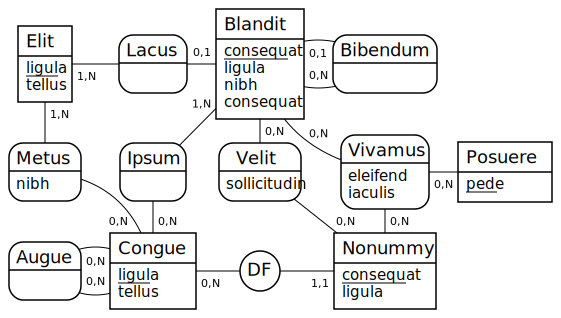

In [ ]:
%%mocodo --arrange
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh
Bibendum, 01 Blandit, 0N Blandit
Blandit: consequat, ligula, nibh, consequat

Ipsum, 1N Blandit, 0N Congue
Congue: ligula, tellus
Augue, 0N Congue, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
DF, 11 Nonummy, 0N Congue

Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
Nonummy: consequat, ligula
::

Si ce réarrangement échoue ou laisse à désirer, il est possible de spécifier chacune des ièmes grilles suivantes avec l'option `--fit=i`:

In [ ]:
%%mocodo --fit=1
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh
    
Bibendum, 01 Blandit, 0N Blandit
Blandit: consequat, ligula, nibh, consequat
Ipsum, 1N Blandit, 0N Congue

Congue: ligula, tellus
Augue, 0N Congue, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
    
DF, 11 Nonummy, 0N Congue
Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
    
Nonummy: consequat, ligula

%%mocodo
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh
Bibendum, 01 Blandit, 0N Blandit

Blandit: consequat, ligula, nibh, consequat
Ipsum, 1N Blandit, 0N Congue
Congue: ligula, tellus
Augue, 0N Congue, 0N Congue

Velit, 0N Blandit, 0N Nonummy: sollicitudin
DF, 11 Nonummy, 0N Congue
Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis

Nonummy: consequat, ligula
:::


%%mocodo
Elit: ligula, tellus
Lacus, 01 Blandit, 1N Elit
Blandit: consequat, ligula, nibh, consequat
Bibendum, 01 Blandit, 0N Blandit

Metus, 1N Elit, 0N Congue: nibh
Ipsum, 1N Blandit, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis

Congue: ligula, tellus
DF, 11 Nonummy, 0N Congue
Nonummy: consequat, ligula
Posuere: pede

Augue, 0N Congue, 0N Congue
:::


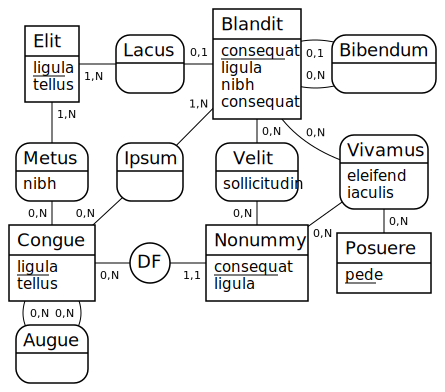

In [ ]:
%%mocodo --arrange
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh
Bibendum, 01 Blandit, 0N Blandit

Blandit: consequat, ligula, nibh, consequat
Ipsum, 1N Blandit, 0N Congue
Congue: ligula, tellus
Augue, 0N Congue, 0N Congue

Velit, 0N Blandit, 0N Nonummy: sollicitudin
DF, 11 Nonummy, 0N Congue
Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis

Nonummy: consequat, ligula
:::

**Remarques.**
- Quand le paramètre de `--fit` définit une grille trop grande, le réarrangement automatique retombe fréquemment sur une sous-grille de celle-ci.
- Dans [Mocodo online](http://mocodo.net), cliquer sur le bouton de réarrangement automatique enchaîne directement les opérations `--fit` et `--arrange`.

## 5.3. Basculement des cardinalités et inflexion des pattes rectilignes <a id='inflexion'></a>

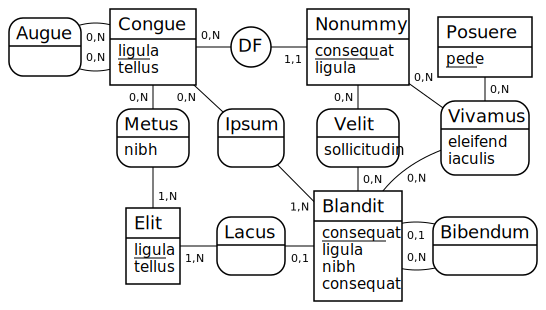

In [ ]:
%%mocodo
Augue, 0N Congue, 0N Congue
Congue: ligula, tellus
DF, 11 Nonummy, 0N Congue
Nonummy: consequat, ligula
Posuere: pede

:
Metus, 1N Elit, 0N Congue: nibh
Ipsum, 1N Blandit, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis

:
Elit: ligula, tellus
Lacus, 01 Blandit, 1N Elit
Blandit: consequat, ligula, nibh, consequat
Bibendum, 01 Blandit, 0N Blandit

**Nouveauté de la version 2.1.** Mocodo est capable de détecter certaines configurations de pattes dont les cardinalités présentent un risque élevé de collision. Il procède alors à deux types d'ajustements:

1. [Issue 25](https://github.com/laowantong/mocodo/issues/25). Les cardinalités d'une patte verticale ou horizontale sont envoyées de l'autre côté de la patte. Par exemple, dans le MCD ci-dessus, la présence de la patte oblique _CONGUE-IPSUM_ envoie les cardinalités de _CONGUE-METUS_ et _CONGUE-DF_ à l'opposé de leur position par défaut (à droite d'une patte verticale ou en bas d'une patte horizontale).
2. [Issue 27](https://github.com/laowantong/mocodo/issues/27). Les pattes obliques sont infléchies de façon à ménager plus d'espace pour afficher deux couples de cardinalités. Ici, l'inflexion de la patte _BLANDIT-VIVAMUS_ permet à ses cardinalités de coexister sans problème avec celles de l'association réflexive.

Ces ajustements automatiques résolvent les problèmes les plus courants. Toutefois, étant antérieurs au tracé proprement dit, ils peuvent seulement minimiser les risques de collision, et non les prévenir totalement. Ils peuvent même en produire d'autres. Ainsi, autour des entités particulièrement pattues, des collisions qui ne se seraient pas produites par défaut seront parfois observées. L'utilisateur a alors deux possibilités:

- modifier à la main les coordonnées des cardinalités en conflit, comme expliqué dans la section suivante;
- diminuer la valeur du paramètre `--flex` (par défaut, `0.75`) pour réduire la courbure de l'inflexion automatique, en allant jusqu'à `0` pour la désactiver totalement ([exemple](#symetries_selon_les_diagonales_transposition)).

## 5.4. Retouches fines <a id='retouches_fines'></a>

### 5.4.1. Par modification du script intermédiaire <a id='par_modification_du_script_intermediaire'></a>

Mocodo, au lieu de générer directement un dessin statique, génère d'abord un script Python, qui lui-même générera le dessin attendu. Cela se fait de façon transparente, sans intervention de l'utilisateur. L'avantage de cette couche supplémentaire est que le script intermédiaire exprime la plupart des positions, non en absolu, mais en relation à d'autres positions, peu nombreuses et qui constituent de fait les véritables paramètres du dessin. Sa capacité à évaluer des formules le rend beaucoup plus souple et puissant que si les valeurs résultantes étaient stockées en dur.

Le script intermédiaire s'appelle par défaut:

- `sandbox_nodebox.py` sur Mac OS X avec NodeBox 1.x installé ;
- `sandbox_svg.py` dans toutes les autres configurations.

Montrons comment retoucher le MCD suivant:

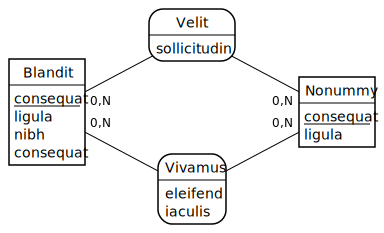

In [ ]:
%%mocodo --shapes trebuchet
Velit, 0N Blandit, 0N Nonummy: sollicitudin

Blandit: consequat, ligula, nibh, consequat
:::
Nonummy: consequat, ligula
    
Vivamus, 0N Nonummy, 0N Blandit: eleifend, iaculis

Si on ouvre le script intermédiaire avec un éditeur de texte, on verra que ses premières instructions exposent les principaux paramètres de position:

```python
(width,height) = (384,233)
cx = {
    u"Velit"  :  192,
    u"Blandit":   47,
    u"Nonummy":  337,
    u"Vivamus":  192,
}
cy = {
    u"Velit"  :   35,
    u"Blandit":  112,
    u"Nonummy":  112,
    u"Vivamus":  189,
}
shift = {
    u"Velit,Blandit"  :    0,
    u"Velit,Nonummy"  :    0,
    u"Vivamus,Nonummy":    0,
    u"Vivamus,Blandit":    0,
}
```

- Un couple de dimensions `width` et `height` définit la taille du MCD;
- deux dictionnaires `cx` et `cy`, les abscisses et ordonnées des centres des boîtes;
- un dictionnaire `shift`, les positions relatives des cardinalités par rapport à leur position par défaut.

Voici les modifications que nous décidons d'apporter au fichier (ignorez la première ligne):

In [ ]:
%%file mocodo_notebook/replace.tmp
(width,height) = (340,153)     # réduire de 40 pixels en largeur et de 80 pixels en hauteur
cx = {
    u"Velit"  :  170,          # décaler de 20 pixels vers la gauche
    u"Blandit":   47,
    u"Nonummy":  293,          # décaler de 40 pixels vers la gauche
    u"Vivamus":  170,          # décaler de 20 pixels vers la gauche
}
cy = {
    u"Velit"  :   35,
    u"Blandit":   72,          # remonter de 40 pixels
    u"Nonummy":   72,          # remonter de 40 pixels
    u"Vivamus":  109,          # remonter de 40 pixels
}
shift = {
    u"Velit,Blandit"  :  -30, # mettre la cardinalité au-dessus de la patte
    u"Velit,Nonummy"  :  -30, # mettre la cardinalité au-dessus de la patte
    u"Vivamus,Nonummy":    0,
    u"Vivamus,Blandit":    0,
}

Writing mocodo_notebook/replace.tmp


Sous Nodebox, il suffit alors de choisir **Run** dans le menu **Python**.

Si vous travaillez avec des fichiers SVG, il faut exécuter le script `..._svg.py`. Il regénère alors le fichier SVG qui contient le dessin. Il ne reste plus qu'à l'ouvrir, par exemple avec un navigateur.

Les lignes suivantes (qu'il est inutile de comprendre) permettent de faire la même chose à l'intérieur de cette documentation.

Fichier de sortie "mocodo_notebook/sandbox.svg" généré avec succès.


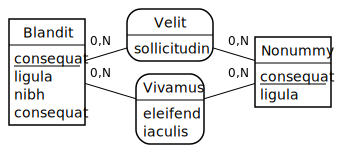

In [ ]:
!cd mocodo_notebook ; sed -i.tmp -e '10,28d' -e '8r replace.tmp' sandbox_svg.py ; rm *.tmp
!python mocodo_notebook/sandbox_svg.py
from IPython.core.display import SVG
SVG("mocodo_notebook/sandbox.svg")

Selon le même principe, on peut faire glisser les flèches le long des arcs (dictionnaire `ratio`) ou modifier les couleurs (dictionnaire `colors`).

Cette technique inhabituelle nous semble une application naturelle du dynamisme du langage Python. Mais c'est à vous de décider si vous êtes plus efficace en ajustant des valeurs numériques, ou en faisant glisser des objets dans votre cliquodrome favori, comme décrit dans la section suivante.

### 5.4.2. Par édition de la sortie au format SVG <a id='par_edition_de_la_sortie_au_format_svg'></a>

Un fichier SVG peut être visualisé dans tout navigateur moderne.

Pour aller au-delà de la simple visualisation, il faudra faire appel à un logiciel de dessin vectoriel dédié, comme [Inkscape](http://www.inkscape.org/?lang=fr) (libre) ou Adobe Illustrator, Freehand, CorelDRAW, etc.
Les éléments du fichier SVG produit pourront alors être repositionnés à la souris. Certains sont associés, pour permettre leur déplacement en bloc. Dans la version actuelle, les liens ne suivent pas ces déplacements, ce qui peut obliger à des manipulations supplémentaires.

## 5.5. Réarrangement par symétrie <a id='rearrangement_par_symetrie'></a>

Mocodo permet de calculer facilement le symétrique d'un MCD, par exemple celui donné ci-dessous:

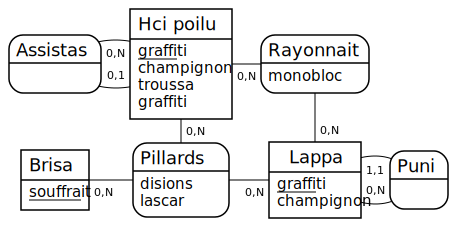

In [ ]:
%%mocodo
Assistas, 01 Hci poilu, 0N Hci poilu
Hci poilu: graffiti, champignon, troussa, graffiti
Rayonnait, 0N Hci poilu, 0N Lappa: monobloc

Brisa: souffrait
Pillards, 0N Brisa, 0N Lappa, 0N Hci poilu: disions, lascar
Lappa: graffiti, champignon
Puni, 11 Lappa, 0N Lappa

**Nouveauté de la version 2.0.20.** Pour remplacer le texte de la cellule par le résultat de son évaluation, ajoutez l'[option `--replace`](#option_replace).

### 5.5.1. Symétrie selon l'axe vertical <a id='symetrie_selon_l_axe_vertical'></a>

%%mocodo
:
Rayonnait, 0N Hci poilu, 0N Lappa: monobloc
Hci poilu: graffiti, champignon, troussa, graffiti
Assistas, 01 Hci poilu, 0N Hci poilu

Puni, 11 Lappa, 0N Lappa
Lappa: graffiti, champignon
Pillards, 0N Brisa, 0N Lappa, 0N Hci poilu: disions, lascar
Brisa: souffrait


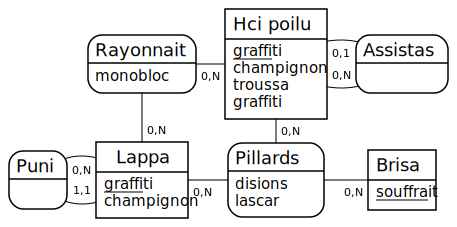

In [ ]:
%%mocodo --flip=v
Assistas, 01 Hci poilu, 0N Hci poilu
Hci poilu: graffiti, champignon, troussa, graffiti
Rayonnait, 0N Hci poilu, 0N Lappa: monobloc

Brisa: souffrait
Pillards, 0N Brisa, 0N Lappa, 0N Hci poilu: disions, lascar
Lappa: graffiti, champignon
Puni, 11 Lappa, 0N Lappa

### 5.5.2. Symétrie selon l'axe horizontal <a id='symetrie_selon_l_axe_horizontal'></a>

%%mocodo
Brisa: souffrait
Pillards, 0N Brisa, 0N Lappa, 0N Hci poilu: disions, lascar
Lappa: graffiti, champignon
Puni, 11 Lappa, 0N Lappa

Assistas, 01 Hci poilu, 0N Hci poilu
Hci poilu: graffiti, champignon, troussa, graffiti
Rayonnait, 0N Hci poilu, 0N Lappa: monobloc
:


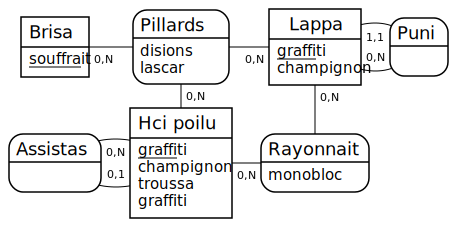

In [ ]:
%%mocodo --flip=h
Assistas, 01 Hci poilu, 0N Hci poilu
Hci poilu: graffiti, champignon, troussa, graffiti
Rayonnait, 0N Hci poilu, 0N Lappa: monobloc

Brisa: souffrait
Pillards, 0N Brisa, 0N Lappa, 0N Hci poilu: disions, lascar
Lappa: graffiti, champignon
Puni, 11 Lappa, 0N Lappa

### 5.5.3. Symétries selon les diagonales (transposition) <a id='symetries_selon_les_diagonales_transposition'></a>

%%mocodo
Assistas, 01 Hci poilu, 0N Hci poilu
Brisa: souffrait

Hci poilu: graffiti, champignon, troussa, graffiti
Pillards, 0N Brisa, 0N Lappa, 0N Hci poilu: disions, lascar

Rayonnait, 0N Hci poilu, 0N Lappa: monobloc
Lappa: graffiti, champignon

:
Puni, 11 Lappa, 0N Lappa


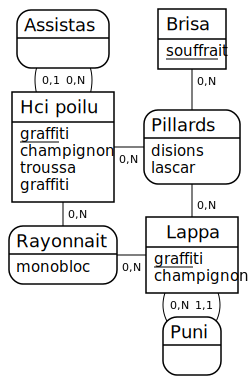

In [ ]:
%%mocodo --flip=d
Assistas, 01 Hci poilu, 0N Hci poilu
Hci poilu: graffiti, champignon, troussa, graffiti
Rayonnait, 0N Hci poilu, 0N Lappa: monobloc

Brisa: souffrait
Pillards, 0N Brisa, 0N Lappa, 0N Hci poilu: disions, lascar
Lappa: graffiti, champignon
Puni, 11 Lappa, 0N Lappa

Pour une symétrie selon l'anti-diagonale, appliquer successivement les trois symétries précédentes dans n'importe quel ordre.

#### 5.5.3.1. Astuce: édition rapide d'une ou plusieurs colonnes <a id='transposition_trick'></a>

La transposition peut être utilisée pour réaliser plus facilement certaines opérations d'édition en colonne, en particulier sous [Mocodo online](http://mocodo.net). Par exemple, supposons que l'on souhaite décaler vers le haut la dernière colonne du MCD ci-dessous:

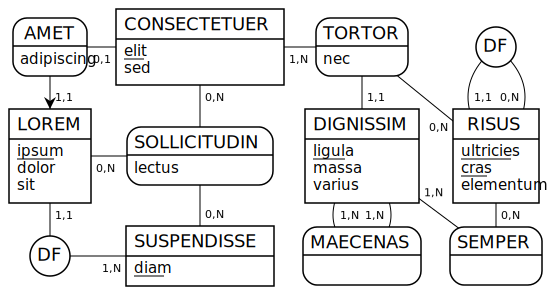

In [ ]:
%%mocodo --flex=0
AMET, 11> LOREM, 01 CONSECTETUER: adipiscing
CONSECTETUER: elit, sed
TORTOR, 0N RISUS, 11 DIGNISSIM, 1N CONSECTETUER: nec
DF, 11 RISUS, 0N RISUS

LOREM: ipsum, dolor, sit
SOLLICITUDIN, 0N SUSPENDISSE, 0N CONSECTETUER, 0N LOREM: lectus
DIGNISSIM: ligula, massa, varius
RISUS: ultricies, _cras, elementum

DF1, 11 LOREM, 1N SUSPENDISSE
SUSPENDISSE: diam
MAECENAS, 1N DIGNISSIM, 1N DIGNISSIM
SEMPER, 0N RISUS, 1N DIGNISSIM

On commence par transposer:

In [ ]:
%%mocodo --no_mcd --flip=d
AMET, 11> LOREM, 01 CONSECTETUER: adipiscing
CONSECTETUER: elit, sed
TORTOR, 0N RISUS, 11 DIGNISSIM, 1N CONSECTETUER: nec
DF, 11 RISUS, 0N RISUS

LOREM: ipsum, dolor, sit
SOLLICITUDIN, 0N SUSPENDISSE, 0N CONSECTETUER, 0N LOREM: lectus
DIGNISSIM: ligula, massa, varius
RISUS: ultricies, _cras, elementum

DF1, 11 LOREM, 1N SUSPENDISSE
SUSPENDISSE: diam
MAECENAS, 1N DIGNISSIM, 1N DIGNISSIM
SEMPER, 0N RISUS, 1N DIGNISSIM

%%mocodo
AMET, 11> LOREM, 01 CONSECTETUER: adipiscing
LOREM: ipsum, dolor, sit
DF1, 11 LOREM, 1N SUSPENDISSE

CONSECTETUER: elit, sed
SOLLICITUDIN, 0N SUSPENDISSE, 0N CONSECTETUER, 0N LOREM: lectus
SUSPENDISSE: diam

TORTOR, 0N RISUS, 11 DIGNISSIM, 1N CONSECTETUER: nec
DIGNISSIM: ligula, massa, varius
MAECENAS, 1N DIGNISSIM, 1N DIGNISSIM

DF, 11 RISUS, 0N RISUS
RISUS: ultricies, _cras, elementum
SEMPER, 0N RISUS, 1N DIGNISSIM


Il suffit alors d'insérer un deux-points au début de chacune des trois premières rangées, puis de retransposer dans l'autre sens:

%%mocodo
:::
DF, 11 RISUS, 0N RISUS

AMET, 11> LOREM, 01 CONSECTETUER: adipiscing
CONSECTETUER: elit, sed
TORTOR, 0N RISUS, 11 DIGNISSIM, 1N CONSECTETUER: nec
RISUS: ultricies, _cras, elementum

LOREM: ipsum, dolor, sit
SOLLICITUDIN, 0N SUSPENDISSE, 0N CONSECTETUER, 0N LOREM: lectus
DIGNISSIM: ligula, massa, varius
SEMPER, 0N RISUS, 1N DIGNISSIM

DF1, 11 LOREM, 1N SUSPENDISSE
SUSPENDISSE: diam
MAECENAS, 1N DIGNISSIM, 1N DIGNISSIM
:


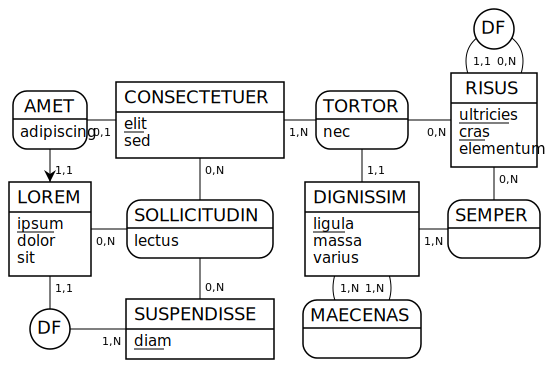

In [ ]:
%%mocodo --flip=d
:
AMET, 11> LOREM, 01 CONSECTETUER: adipiscing
LOREM: ipsum, dolor, sit
DF1, 11 LOREM, 1N SUSPENDISSE

:
CONSECTETUER: elit, sed
SOLLICITUDIN, 0N SUSPENDISSE, 0N CONSECTETUER, 0N LOREM: lectus
SUSPENDISSE: diam

:
TORTOR, 0N RISUS, 11 DIGNISSIM, 1N CONSECTETUER: nec
DIGNISSIM: ligula, massa, varius
MAECENAS, 1N DIGNISSIM, 1N DIGNISSIM

DF, 11 RISUS, 0N RISUS
RISUS: ultricies, _cras, elementum
SEMPER, 0N RISUS, 1N DIGNISSIM


On peut se convaincre en examinant le nouveau texte d'entrée que le résultat aurait été beaucoup plus pénible à obtenir en procédant directement.

## 5.6. Réarrangement automatique <a id='rearrangement_automatique'></a>

Il est possible de demander à Mocodo de chercher tout seul une « bonne » permutation des boîtes, ce qui à la main deviendrait vite difficile.

Le critère que nous avons retenu pour évaluer la qualité d'une permutation est double:

1. les liens ne doivent pas se couper;
2. leur longueur cumulée doit être minimale.

Trois algorithmes sont fournis:

- un algorithme exact (`bb`, pour _Branch & Bound_), qui ne trouve que des solutions satisfaisant aux deux critères;
- un algorithme approché (`ga`, pour _Genetic Algorithm_), réservé aux cas où il est impossible de satisfaire au premier critère. L'algorithme va alors chercher des solutions où les liens se coupent seulement le moins possible;
- un autre algorithme exact (`lp`, pour _Linear Programming_), mais reposant sur un solveur générique (actuellement, [CPLEX](https://www-01.ibm.com/software/commerce/optimization/cplex-optimizer/) ou [Gurobi](http://gurobi.com)).

**Nouveauté de la version 2.0.20.** Pour remplacer le texte de la cellule par le résultat de son évaluation, ajoutez l'[option `--replace`](#option_replace).

### 5.6.1. Méthode exacte spécialisée <a id='methode_exacte'></a>

#### 5.6.1.1. À l'intérieur d'une grille prédéfinie <a id='non_organic'></a>

Voici à titre d'exemple un résultat trouvé par l'algorithme exact, suivi du MCD correspondant:

%%mocodo
Metus, 1N Elit, 0N Congue: nibh
Congue: ligula, tellus
Augue, 0N Congue, 0N Congue
:

Elit: ligula, tellus
Ipsum, 1N Blandit, 0N Congue
DF, 11 Nonummy, 0N Congue
:

Lacus, 01 Blandit, 1N Elit
Blandit: consequat, ligula, nibh, consequat
Velit, 0N Blandit, 0N Nonummy: sollicitudin
Nonummy: consequat, ligula

:
Bibendum, 01 Blandit, 0N Blandit
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
Posuere: pede


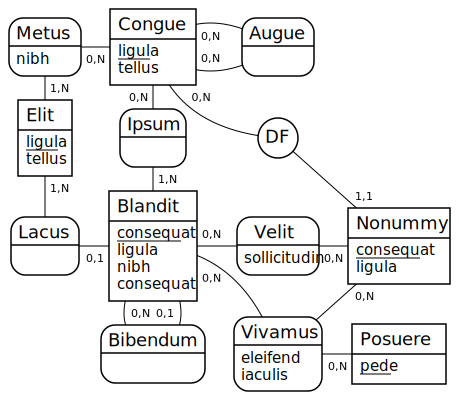

In [ ]:
%%mocodo --arrange --seed=1
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh

Bibendum, 01 Blandit, 0N Blandit
Blandit: consequat, ligula, nibh, consequat
Ipsum, 1N Blandit, 0N Congue
Congue: ligula, tellus
Augue, 0N Congue, 0N Congue

Velit, 0N Blandit, 0N Nonummy: sollicitudin
DF, 11 Nonummy, 0N Congue

Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
Nonummy: consequat, ligula

Le réarrangement automatique se fera toujours à l'intérieur d'une grille ayant autant de colonnes et de rangées que le texte de départ (ici, $4\times5$). On peut quelquefois essayer de réduire cette grille. Par exemple, le MCD ci-dessus comporte 13 boîtes. Elles pourraient donc théoriquement tenir dans une grille $5\times3=15$. Modifions le texte à la main pour avoir 3 blocs d'au plus 5 lignes, et vérifier qu'un tel réarrangement est possible:

%%mocodo
Augue, 0N Congue, 0N Congue
Congue: ligula, tellus
DF, 11 Nonummy, 0N Congue
Nonummy: consequat, ligula
Posuere: pede

:
Metus, 1N Elit, 0N Congue: nibh
Ipsum, 1N Blandit, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis

:
Elit: ligula, tellus
Lacus, 01 Blandit, 1N Elit
Blandit: consequat, ligula, nibh, consequat
Bibendum, 01 Blandit, 0N Blandit


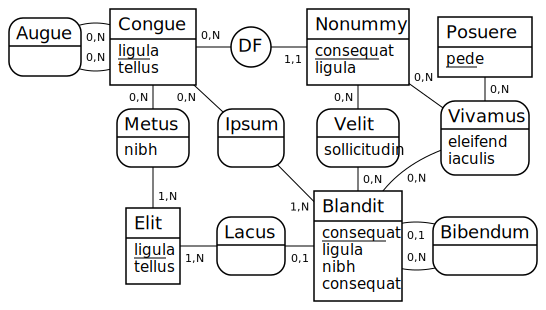

In [ ]:
%%mocodo --arrange --seed=4
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh
Bibendum, 01 Blandit, 0N Blandit
Blandit: consequat, ligula, nibh, consequat

Ipsum, 1N Blandit, 0N Congue
Congue: ligula, tellus
Augue, 0N Congue, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
DF, 11 Nonummy, 0N Congue

Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
Nonummy: consequat, ligula

#### 5.6.1.2. Par croissance organique <a id='organic'></a>

Le réarrangement dit organique consiste à choisir une première boîte au hasard, puis à essayer d'agréger les autres sans se préoccuper de contenir le tout dans une grille prédéterminée.

%%mocodo
:
Augue, 0N Congue, 0N Congue
::

:
Congue: ligula, tellus
:
DF, 11 Nonummy, 0N Congue

Metus, 1N Elit, 0N Congue: nibh
Ipsum, 1N Blandit, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
Nonummy: consequat, ligula

Elit: ligula, tellus
Lacus, 01 Blandit, 1N Elit
Blandit: consequat, ligula, nibh, consequat
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis

::
Bibendum, 01 Blandit, 0N Blandit
Posuere: pede


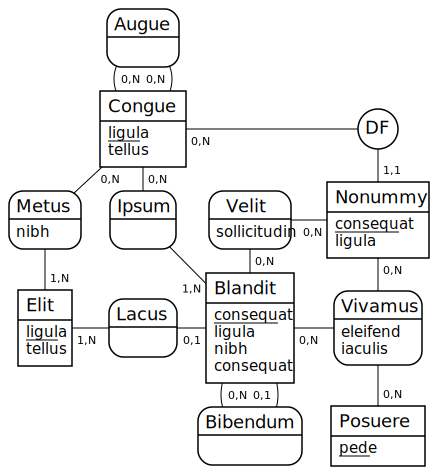

In [ ]:
%%mocodo --arrange --organic --seed=14
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh
Bibendum, 01 Blandit, 0N Blandit
Blandit: consequat, ligula, nibh, consequat

Ipsum, 1N Blandit, 0N Congue
Congue: ligula, tellus
Augue, 0N Congue, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
DF, 11 Nonummy, 0N Congue

Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
Nonummy: consequat, ligula

Cela donne un autre plongement du MCD sur une grille $4\times5$, ce qui comme on l'a vu n'est pas optimal. En fait, le résultat d'une réorganisation organique peut souvent être trivialement amélioré, par exemple ici en faisant pivoter _Augue_ et en décalant _DF_:

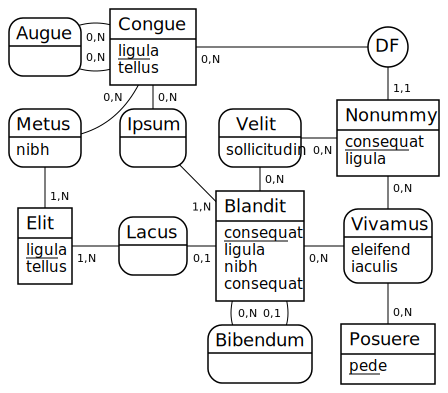

In [ ]:
%%mocodo
Augue, 0N Congue, 0N Congue
Congue: ligula, tellus
:
DF, 11 Nonummy, 0N Congue

Metus, 1N Elit, 0N Congue: nibh
Ipsum, 1N Blandit, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
Nonummy: consequat, ligula

Elit: ligula, tellus
Lacus, 01 Blandit, 1N Elit
Blandit: consequat, ligula, nibh, consequat
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis

::
Bibendum, 01 Blandit, 0N Blandit
Posuere: pede

De fait, le réarrangement organique fournit souvent un bon point de départ pour chercher soi-même une permutation plus esthétique ou mettant en évidence certaines propriétés du MCD.

 #### Limitations

Pour permettre au programme de rendre plus rapidement de bonnes solutions, on a borné arbitrairement le nombre d'appels à la fonction chargée de construire une permutation à partir du placement de la première boîte. De ce fait, l'algorithme n'est plus exact, en ce sens que la meilleure solution peut occasionnellement lui échapper. Si vous soupçonnez que c'est le cas, faites un autre essai, éventuellement en augmentant la borne (par défaut 10000):
```shell
mocodo --arrange --call_limit=100000
```
Et pour en avoir complètement le cœur net, lancez le solveur de programmes linéaires:
```shell
mocodo --arrange=lp
```

D'autre part, le réarrangement exact ne fonctionnera jamais sur les MCD:
    
- non planaires;
- planaires n'admettant aucun plongement planaire dans les limites de la grille spécifiée.

Rappelons qu'un graphe est dit [planaire](https://fr.wikipedia.org/wiki/Graphe_planaire) lorsqu'il en existe au moins un arrangement sans croisement. Le graphe non planaire comportant le plus petit nombre de liens est connu sous le nom de [$K_{3,3}$](http://www.nomachetejuggling.com/2011/10/29/why-the-complete-bipartite-graph-k33-is-not-planar/):

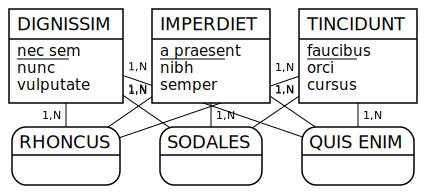

In [ ]:
%%mocodo
DIGNISSIM: nec sem, nunc, vulputate
IMPERDIET: a praesent, nibh, semper
TINCIDUNT: faucibus, orci, cursus

RHONCUS, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
SODALES, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
QUIS ENIM, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT

Son réarrangement échoue donc:

In [ ]:
%%mocodo --arrange
DIGNISSIM: nec sem, nunc, vulputate
IMPERDIET: a praesent, nibh, semper
TINCIDUNT: faucibus, orci, cursus

RHONCUS, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
SODALES, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
QUIS ENIM, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT

ERROR: Mocodo Err.9 - Impossible de calculer une mise en page planaire.


### 5.6.2. Méthode heuristique <a id='methode_heuristique'></a>

Dans tous ces cas, on pourra se rabattre sur l'heuristique. Celle-ci, au lieu d'interdire les croisements, cherche simplement à en minimiser le nombre.

%%mocodo
DIGNISSIM: nec sem, nunc, vulputate
RHONCUS, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
IMPERDIET: a praesent, nibh, semper

SODALES, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
TINCIDUNT: faucibus, orci, cursus
QUIS ENIM, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT


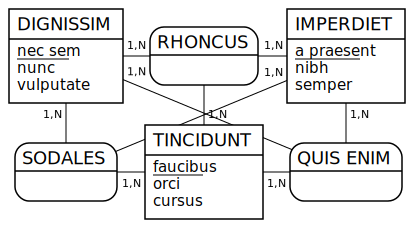

In [ ]:
%%mocodo --arrange=ga --seed=42
DIGNISSIM: nec sem, nunc, vulputate
IMPERDIET: a praesent, nibh, semper
TINCIDUNT: faucibus, orci, cursus

RHONCUS, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
SODALES, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
QUIS ENIM, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT

L'amélioration ne saute pas forcément aux yeux, mais il n'y a plus que 3 croisements au lieu de 9. Ce plongement constitue en tout cas un bon point de départ pour un réarrangement manuel. Pour arriver à une représentation lisible, il ne reste plus qu'à insérer quelques boîtes invisibles:

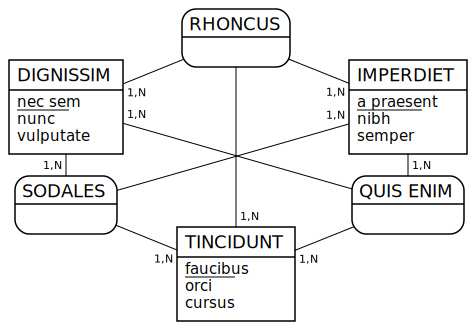

In [ ]:
%%mocodo
RHONCUS, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT

DIGNISSIM: nec sem, nunc, vulputate
:::
IMPERDIET: a praesent, nibh, semper

SODALES, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
:::
QUIS ENIM, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT

TINCIDUNT: faucibus, orci, cursus

### 5.6.3. Méthode exacte générique <a id='methode_exacte_generique'></a>

**Nouveauté de la version 2.2.** Cette méthode, invoquée avec le paramètre `arrange=lp`, trouvera nécessairement l'une des meilleures solutions, pour peu que celle-ci existe et que vous ayez du temps devant vous.

L'idée est de convertir le problème en [programme linaire](https://fr.wikipedia.org/wiki/Optimisation_linéaire), de l'envoyer à un solveur externe, et de récupérer le résultat à la fin.

Actuellement, le solveur peut être [CPLEX](http://www-01.ibm.com/software/commerce/optimization/cplex-optimizer/):

%%mocodo
Bibendum, 01 Blandit, 0N Blandit
Blandit: consequat, ligula, nibh, consequat
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
:

Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
Velit, 0N Blandit, 0N Nonummy: sollicitudin
Ipsum, 1N Blandit, 0N Congue
Metus, 1N Elit, 0N Congue: nibh
:

Posuere: pede
Nonummy: consequat, ligula
DF, 11 Nonummy, 0N Congue
Congue: ligula, tellus
Augue, 0N Congue, 0N Congue


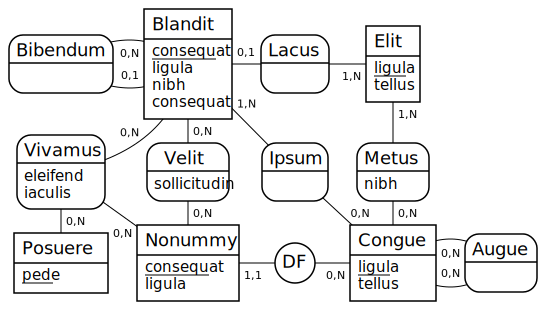

In [ ]:
%%mocodo --arrange=lp --engine=cplex
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh
Bibendum, 01 Blandit, 0N Blandit
Blandit: consequat, ligula, nibh, consequat

Ipsum, 1N Blandit, 0N Congue
Congue: ligula, tellus
Augue, 0N Congue, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
DF, 11 Nonummy, 0N Congue

Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
Nonummy: consequat, ligula

... Ou [Gurobi](http://gurobi.com):

%%mocodo
Augue, 0N Congue, 0N Congue
Congue: ligula, tellus
DF, 11 Nonummy, 0N Congue
Nonummy: consequat, ligula
:

Metus, 1N Elit, 0N Congue: nibh
Ipsum, 1N Blandit, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
Posuere: pede

Elit: ligula, tellus
Lacus, 01 Blandit, 1N Elit
Blandit: consequat, ligula, nibh, consequat
Bibendum, 01 Blandit, 0N Blandit
:


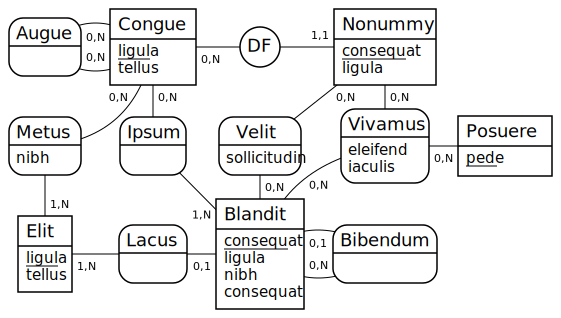

In [ ]:
%%mocodo --arrange=lp --engine=gurobi
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh
Bibendum, 01 Blandit, 0N Blandit
Blandit: consequat, ligula, nibh, consequat

Ipsum, 1N Blandit, 0N Congue
Congue: ligula, tellus
Augue, 0N Congue, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
DF, 11 Nonummy, 0N Congue

Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
Nonummy: consequat, ligula

**Remarques.**

- Ces résultats, même s'ils semblent différents, sont exactement équivalents en termes de longueur cumulée des liens.
- Les deux solveurs sont des logiciels commerciaux, qui ne sont donc pas livrés avec Mocodo. Toutefois, si vous êtes étudiant ou chercheur en université, vous pouvez faire une demande de licence académique gratuite auprès de leurs éditeurs respectifs.
- Actuellement, le temps de résolution par solveur générique est souvent rédhibitoire. L'option n'a été introduite qu'à des fins de recherche, et ne présente pas d'intérêt pratique pour l'utilisateur final.

## 5.7. Conversion dans d'autres formats graphiques <a id='conversion_dans_d_autres_formats_graphiques'></a>

L'exportation est déléguée à votre éditeur SVG ou à Nodebox. Le format PDF assure la meilleure qualité, aussi bien pour la visualisation sur écran, que pour la projection ou l'impression. Si vous devez absolument utiliser un format bitmap, préférez PNG ou GIF.

# 6. Passage au relationnel <a id='passage_au_relationnel'></a>

Le passage au relationnel se fait en deux étapes:
- la création d'une représentation **interne** complète du MLD;
- la traduction de celle-ci en une représentation **externe** dans le ou les formats de sortie souhaités.

## 6.1. Construction de la représentation interne <a id='construction_de_la_representation_interne'></a>

### 6.1.1. Cas réguliers <a id='regular_mld_conversion'></a>

La séquence d'opérations suivante est réalisée:

1. Pour chaque entité, une relation (table) de même nom et de mêmes attributs est créée. Le ou les identifiants de l'entité constituent la clef primaire de la relation.
2. Toute relation issue d'une entité faible est renforcée, c'est-à-dire que la clef primaire de l'entité qu'elle détermine fonctionnellement vient s'adjoindre à sa clef primaire, au besoin de façon récursive.
3. Les associations sont traitées ainsi:
  1. si toutes les pattes de l'association portent la cardinalité maximale N, une relation de même nom et de mêmes attributs est créée. Sa clef primaire est constituée de l'ensemble des clefs primaires des relations issues des entités mises en jeu;
  2. dans le cas contraire, c'est-à-dire si l'une des pattes de l'association porte la cardinalité (1,1), ou à défaut (0,1), l'entité distinguée se voit adjoindre:
    1. en tant que clefs étrangères, l'ensemble des clefs primaires des autres entités mises en jeu;
    2. en tant que simples attributs, l'ensemble des attributs de l'association.

**Remarque.** Un couple de cardinalités non standard, c'est-à-dire distinct de (0,1), (1,1), (0,N) et (1,N), est traité comme (0,1) si son deuxième symbole est un 1, et comme (0,N) sinon. Cela couvre en particulier les cas (\*, 1), (\*,N), (?,?) et (X,X).

#### 6.1.1.1. Exemple du traitement des associations non DF <a id='exemple_du_traitement_des_associations_non_df'></a>

Illustrons le premier cas du troisième point sur un MCD comportant des associations triple, double et réflexive dont toutes les cardinalités maximales sont à N.

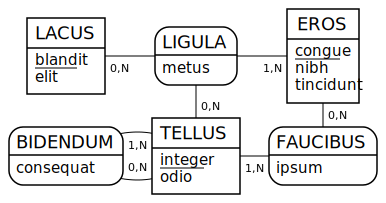

In [ ]:
%%mocodo --mld
LACUS: blandit, elit
LIGULA, 0N LACUS, 1N EROS, 0N TELLUS: metus
EROS: congue, nibh, tincidunt    

BIDENDUM, 0N TELLUS, 1N TELLUS: consequat
TELLUS: integer, odio
FAUCIBUS, 1N TELLUS, 0N EROS: ipsum

Notez la [désambiguïsation automatique par numérotation](#disambiguation_by_number) du deuxième attribut de BIBENDUM.

#### 6.1.1.2. Exemple du traitement des associations DF <a id='exemple_du_traitement_des_associations_df'></a>

Illustrons l'autre cas sur un MCD quasiment identique, à ceci près que certaines cardinalités maximales ont été ramenées à 1. En tant que dépendances fonctionnelles, toutes les associations vont alors disparaître.

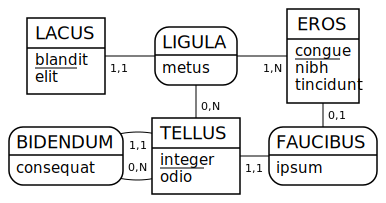

In [ ]:
%%mocodo --mld
LACUS: blandit, elit
LIGULA, 11 LACUS, 1N EROS, 0N TELLUS: metus
EROS: congue, nibh, tincidunt    

BIDENDUM, 0N TELLUS, 11 TELLUS: consequat
TELLUS: integer, odio
FAUCIBUS, 11 TELLUS, 01 EROS: ipsum

Notez les points suivants:
- la cardinalité (1,1) est par défaut prioritaire sur (0,1) lors du traitement de l'association FAUCIBUS;
- Mocodo n'impose pas de borne supérieure à l'arité d'une association de dépendance fonctionnelle, ici par exemple LIGULA est ternaire (alternative: modélisation par plusieurs dépendances fonctionnelles);
- Mocodo n'interdit pas à une association de dépendance fonctionnelle de porter des attributs (alternative: les mettre dans l'entité distinguée par (1,1)).

Les deux alternatives mentionnées, plus orthodoxes mais plus lourdes, produisent de toute façon le même schéma relationnel. Autre point litigieux, cette fois non pris en charge par Mocodo: dans les dépendances fonctionnelles à double sens ((1,1) des deux côtés), la priorité est donnée de façon non spécifiée à l'un des (1,1).

#### 6.1.1.3. Exemple du traitement des entités faibles (identification relative) <a id='weak_entities_relational'></a>

**Nouveauté.** Les renforcements en cascade sont correctement gérés dans tous les cas, et les renforcements cycliques produisent un message d'erreur.

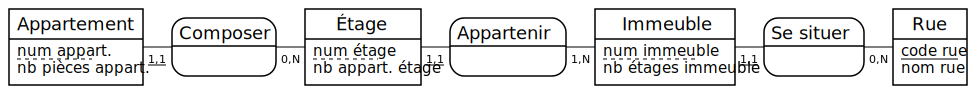

In [ ]:
%%mocodo --mld --relations diagram
Appartement: num appart., nb pièces appart.
Composer, 0N Étage, _11 Appartement
Étage: num étage, nb appart. étage
Appartenir, 1N Immeuble, _11 Étage
Immeuble: num immeuble, nb étages immeuble
Se situer, 0N Rue, _11 Immeuble
Rue: code rue, nom rue

Dans ce joli exemple dû à Idris NEUMANN, [_Initiation à la conception de bases de données relationnelles avec MERISE_](http://ineumann.developpez.com/tutoriels/merise/initiation-merise/#LIV-A), les renforcements successifs aboutissent à faire entrer l'identifiant de RUE dans celui de APPARTEMENT, alors même que ces entités sont séparées par non moins de trois associations.

Ce processus apparaît clairement sur le [diagramme relationnel](#relational_diagram) généré par la commande précédente:

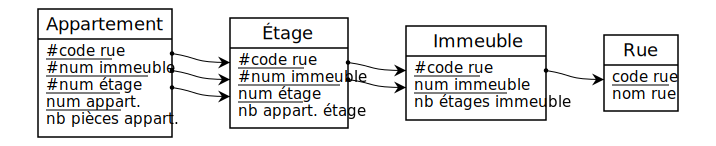

In [ ]:
%mocodo --input mocodo_notebook/sandbox.mld

#### 6.1.1.4. Rétablissement explicite de la sémantique des DF disparues <a id='retablissement_semantique_df'></a>

Mocodo permet de modifier légèrement le nom d'une clef étrangère, de façon à réintroduire la sémantique perdue lors de la disparition de l'association de dépendance fonctionnelle par laquelle elle a migré.

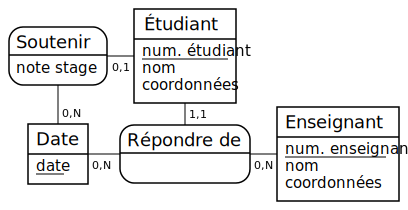

In [ ]:
%%mocodo --mld
Soutenir, 01 Étudiant, 0N Date: note stage
Étudiant: num. étudiant, nom, coordonnées

Date: date
Répondre de, 0N Date, 11 Étudiant, 0N Enseignant
Enseignant: num. enseignant, nom, coordonnées

Par exemple, ci-dessus, la conversion en relationnel produit dans la relation ÉTUDIANT des clefs étrangères _date_ et _date.1_ qui ne peuvent être laissées en l'état. Éventuellement, on peut souhaiter expliciter la présence d'un numéro d'enseignant dans ÉTUDIANT.

Dans les deux cas, il suffit d'employer le système d'annotation de pattes introduit [plus haut](#leg_annotation_description):

In [ ]:
%%mocodo --mld --no_mcd
Soutenir, 01 Étudiant, 0N [soutenance] Date: note stage
Étudiant: num. étudiant, nom, coordonnées

Date: date
Répondre de, 0N [visite] Date, 11 Étudiant, 0N [responsable] Enseignant
Enseignant: num. enseignant, nom, coordonnées

De façon moins cruciale, la technique s'applique aussi aux autres types d'association:

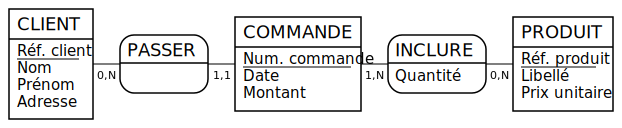

In [ ]:
%%mocodo --mld
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N [ayant commandé] CLIENT, 11 [annotation ignorée] COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N [passée] COMMANDE, 0N [commandé] PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

Pour désactiver cette fonctionnalité (notamment dans le cas où vous annotez chaque cardinalité d'une explication destinée aux novices), passez l'option `--disambiguation=numbers_only`.

### 6.1.2. Cas irréguliers <a id='cas_irreguliers'></a>

Les règles de gestion peuvent parfois conduire à remettre en cause l'application mécanique de l'[algorithme de conversion](#regular_mld_conversion). Mocodo est capable de traiter certaines exceptions, pourvu qu'elles lui soient indiquées.

#### 6.1.2.1. Réduire une clef primaire <a id='reduire_une_clef_primaire'></a>

Il arrive qu'un sous-ensemble strict de l'ensemble des identifiants des entités mises en jeu dans une association dont toutes les pattes portent la cardinalité N, suffise à constituer la clef primaire de la table issue de cette association: cela se fait facilement au niveau relationnel en faisant perdre leur caractère identifiant aux clefs n'appartenant pas à ce sous-ensemble. Pour obtenir le même résultat avec Mocodo, il suffit de préfixer les entités concernées par une barre oblique.

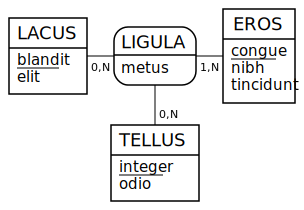

In [ ]:
%%mocodo --mld
LACUS: blandit, elit
LIGULA, 0N LACUS, 1N /EROS, 0N TELLUS: metus
EROS: congue, nibh, tincidunt

TELLUS: integer, odio

La barre oblique de EROS n'apparaît pas dans le MCD, mais conduit à la réduction de la clef primaire de LIGULA aux seuls identifiants des deux autres entités mises en jeu.

#### 6.1.2.2. Minimiser le nombre de champs vides <a id='minimiser_le_nombre_de_champs_vides'></a>

On a vu qu'en l'absence d'une cardinalité (1,1), Mocodo traitait par défaut la cardinalité (0,1) comme une dépendance fonctionnelle. Or, lorsque le 0 est grand devant le 1 en termes de fréquence d'apparition, la plupart des occurrences de la clef étrangère ainsi constituée restent vides. On aura alors intérêt à forcer la conversion de l'association en table. Cela se fait en préfixant d'une barre oblique l'une au moins des entités non distinguées par le (0,1).

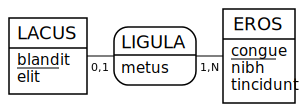

In [ ]:
%%mocodo --mld
LACUS: blandit, elit
LIGULA, 01 LACUS, 1N /EROS: metus
EROS: congue, nibh, tincidunt

## 6.2. Construction de représentations externes <a id='external_representations'></a>

La représentation interne peut être dérivée en représentation externe par l'application d'une spécification de format, ou **gabarit** (_template_ en anglais). Les schémas relationnels affichés au-dessous des diagrammes conceptuels dans la présente section sont un exemple de sortie au format HTML.

### 6.2.1. Gabarits inclus dans la distribution <a id='gabarits_inclus_dans_la_distribution'></a>

#### 6.2.1.1. Formats linéaires <a id='linear_formats'></a>

Dans sa représentation la plus compacte, un schéma relationnel s'écrit comme une suite de lignes de la forme:

    RELATION ( clef_primaire, attribut_1, attribut_2, ...)

Sauf mention contraire, les MLD affichés dans ce document ont été produits par Mocodo au format HTML. Pour un autre exemple, voici la génération et l'affichage d'une sortie $\mathrm\LaTeX$:

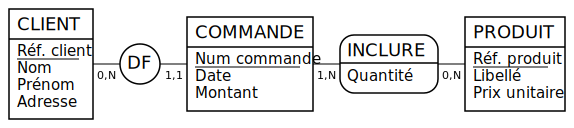

In [ ]:
%%mocodo --relations latex
CLIENT: Réf. client, Nom, Prénom, Adresse
DF, 0N CLIENT, 11 COMMANDE
COMMANDE: Num commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

In [ ]:
# %load mocodo_notebook/sandbox.tex

```
% Copy this before \begin{document}

\usepackage[normalem]{ulem}
\newenvironment{mld}
  {\par\begin{minipage}{\linewidth}\begin{tabular}{rp{0.7\linewidth}}}
  {\end{tabular}\end{minipage}\par}
\newcommand{\relat}[1]{\textsc{#1}}
\newcommand{\attr}[1]{\emph{#1}}
\newcommand{\prim}[1]{\uline{#1}}
\newcommand{\foreign}[1]{\#\textsl{#1}}

% Copy that after \begin{document}

\begin{mld}
  Client & (\prim{Réf. client}, \attr{Nom}, \attr{Prénom}, \attr{Adresse})\\
  Commande & (\prim{Num commande}, \attr{Date}, \attr{Montant}, \foreign{Réf. client})\\
  Inclure & (\foreign{\prim{Num commande}}, \foreign{\prim{Réf. produit}}, \attr{Quantité})\\
  Produit & (\prim{Réf. produit}, \attr{Libellé}, \attr{Prix unitaire})\\
\end{mld}
```

Les formats linéaires actuellement pris en charge par Mocodo sont les suivants:

| Nom | Argument | Usage du fichier généré |
|--|
| [HTML](http://fr.wikipedia.org/wiki/HTML) | html | À ouvrir directement avec un navigateur internet ou un programme de traitement de texte (dont Microsoft Word, OpenOffice, Apple Pages, etc.). Implicite dans un Notebook. |
| [$\mathrm\LaTeX$](http://fr.wikipedia.org/wiki/LaTeX) | latex | À compiler sous $\mathrm\LaTeX$ pour une sortie de haute qualité aux formats PDF ou PostScript. |
| [Markdown](http://fr.wikipedia.org/wiki/Markdown) | markdown |  À coller dans une cellule de Notebook, dans un champ textuel de GitHub ou Stack Overflow, ou à ouvrir avec l'un des nombreux éditeurs Markdown existants. |
| [Texte brut](http://fr.wikipedia.org/wiki/Fichier_texte) | text | À ouvrir directement avec un éditeur de texte Unicode. |
| [Txt2tags](http://fr.wikipedia.org/wiki/txt2tags) | txt2tags | À compiler avec le générateur de documents [Txt2tags](http://txt2tags.sourceforge.net/) pour une conversion dans de nombreux autres formats: HTML, XHTML, SGML, LaTeX, Lout, Man page, Wikipedia, Google Code Wiki, DokuWiki, MoinMoin, MagicPoint, PageMaker, texte brut. Non disponible sous Mocodo online. |

#### 6.2.1.2. Formats linéaires avec explications <a id='formats_lineaires_avec_explications'></a>

Deux de ces formats, HTML et Markdown, disposent maintenant d'une version augmentée d'explications détaillées du mécanisme du passage au relationnel. Ce type de sortie, adaptable par l'enseignant, peut être utile aux étudiants qui souhaitent réviser ou travailler en autonomie.

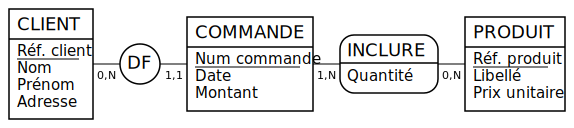

In [ ]:
%%mocodo --relations markdown_verbose
CLIENT: Réf. client, Nom, Prénom, Adresse
DF, 0N CLIENT, 11 COMMANDE
COMMANDE: Num commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

In [ ]:
# %load mocodo_notebook/sandbox_verbose.md

**CLIENT** (<u>Réf. client</u>, Nom, Prénom, Adresse)  
- Le champ _Réf. client_ constitue la clef primaire de la table. C'était déjà un identifiant de l'entité _CLIENT_.  
- Les champs _Nom_, _Prénom_ et _Adresse_ étaient déjà de simples attributs de l'entité _CLIENT_.  

**COMMANDE** (<u>Num commande</u>, Date, Montant, _Réf. client_)  
- Le champ _Num commande_ constitue la clef primaire de la table. C'était déjà un identifiant de l'entité _COMMANDE_.  
- Les champs _Date_ et _Montant_ étaient déjà de simples attributs de l'entité _COMMANDE_.  
- Le champ _Réf. client_ est une clef étrangère. Il a migré à partir de l'entité _CLIENT_ par l'association de dépendance fonctionnelle _DF_ en perdant son caractère identifiant.  

**INCLURE** (<u>_Num commande_</u>, <u>_Réf. produit_</u>, Quantité)  
- Le champ _Num commande_ fait partie de la clef primaire de la table. C'est une clef étrangère qui a migré directement à partir de l'entité _COMMANDE_.  
- Le champ _Réf. produit_ fait partie de la clef primaire de la table. C'est une clef étrangère qui a migré directement à partir de l'entité _PRODUIT_.  
- Le champ _Quantité_ était déjà un simple attribut de l'association _INCLURE_.  

**PRODUIT** (<u>Réf. produit</u>, Libellé, Prix unitaire)  
- Le champ _Réf. produit_ constitue la clef primaire de la table. C'était déjà un identifiant de l'entité _PRODUIT_.  
- Les champs _Libellé_ et _Prix unitaire_ étaient déjà de simples attributs de l'entité _PRODUIT_.

Tout ce texte est généré automatiquement, mais avec des raffinements destinés à le rendre plus lisible pour un humain. Par exemple, les trois attributs non identifiants de l'entité CLIENT sont décrits en une seule ligne au lieu de trois.

#### 6.2.1.3. Diagramme relationnel <a id='relational_diagram'></a>

La plupart des SGBD offrent une représentation hybride (graphique / texte) de la base, sous la forme d'un ensemble de tables rectangulaires liées par des flèches. Mocodo génère maintenant un fichier d'extension `.mld` qu'il est capable de reprendre en entrée pour tracer ce type de graphe.

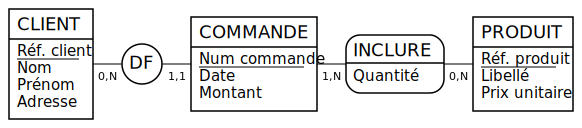

In [ ]:
%%mocodo --relations diagram
CLIENT: Réf. client, Nom, Prénom, Adresse
DF, 0N CLIENT, 11 COMMANDE
COMMANDE: Num commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

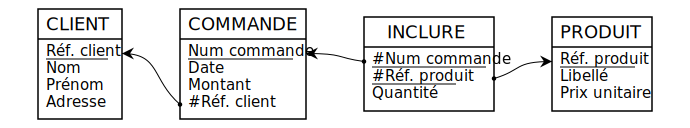

In [ ]:
%mocodo --input mocodo_notebook/sandbox.mld

In [ ]:
# %load mocodo_notebook/sandbox.mld
%%mocodo
:
CLIENT: Réf. client, Nom, Prénom, Adresse
:
COMMANDE: Num commande, Date, Montant, #Réf. client->CLIENT->Réf. client
:
INCLURE: #Num commande->COMMANDE->Num commande, _#Réf. produit->PRODUIT->Réf. produit, Quantité
:
PRODUIT: Réf. produit, Libellé, Prix unitaire
:

Si l'on ouvre le fichier généré (_cf._ ci-dessus), on constate que la syntaxe d'un MLD est la même que celle d'un MCD, à ceci près que les associations sont remplacées par des liens allant de l'attribut `a1` de l'entité `E1` à l'attribut `a2` de l'entité `E2`, et qui se notent: `E1: ... a1->E2->a2`.

Les boîtes invisibles automatiquement insérées une colonne sur deux aèrent le résultat de façon à laisser de la place aux flèches.

Remarquons que ce pseudo-MCD est un « point fixe » de l'opération de passage au relationnel, c'est-à-dire qu'il redonne le même MLD que le MCD de départ:

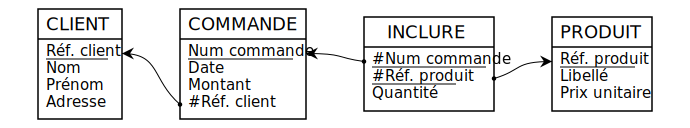

In [ ]:
%%mocodo --relations diagram
:
CLIENT: Réf. client, Nom, Prénom, Adresse
:
COMMANDE: Num commande, Date, Montant, #Réf. client->CLIENT->Réf. client
:
INCLURE: #Num commande->COMMANDE->Num commande, _#Réf. produit->PRODUIT->Réf. produit, Quantité
:
PRODUIT: Réf. produit, Libellé, Prix unitaire
:

Mais cette fois, comme le « MCD » d'entrée ne comporte aucune association, le diagramme relationnel généré ne comporte aucune flèche.

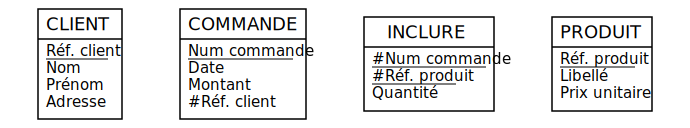

In [ ]:
%mocodo --input mocodo_notebook/sandbox.mld

Le reprendre comme texte d'entrée produit donc le même diagramme, mais sans les flèches. Leur rétablissement pourrait faire l'objet d'un exercice facile.

Sous _Mocodo online_, vous obtiendrez le premier diagramme relationnel en trois étapes:

1. générez les relations correspondant au MCD de départ (vous aurez coché « diagramme relationnel » dans le menu « Options »);
2. copiez-collez la sortie « diagramme relationnel » à la place du texte d'entrée;
3. regénérez les relations.

Les relations sont placées dans le même ordre que les boîtes du MCD d'origine, mais vous devrez souvent les réorganiser (automatiquement ou manuellement) pour obtenir un résultat plus esthétique.

Le diagramme relationnel sans flèches s'obtient en répétant les étapes 2 et 3.

Les versions successives des différents fichiers étant écrasées à chaque regénération, veillez à télécharger l'archive après chaque étape si vous souhaitez garder l'ensemble.

**Limitation.** Les clefs étrangères composites sont actuellement représentées comme si elles étaient séparées (autant de flèches que de parties).

**Nouveauté de la version 2.3.5.** Les tables réduites à une clef primaire non composite sont supprimées et les éventuelles clefs étrangères correspondantes perdent leur caractère étranger. Ainsi, dans le diagramme relationnel de l'[introduction](#introduction), les tables MATIÈRE et DATE ont disparu et les clefs étrangères _libellé matière_ et _date_ ne sont pas préfixées d'un dièse ou accompagnées d'une flèche.

#### 6.2.1.4. Sorties SQL <a id='sql_generation'></a>

Mocodo est livré avec des fichiers de spécification pour les dialectes SQL suivants:

| SGBD | Argument | Suffixe et extension |
|--|
| [MySQL](https://www.mysql.fr) | `--relations mysql` | `"_mysql.sql"` |
| [Oracle](http://oracle.com) | `--relations oracle` | `"_oracle.sql"` |
| [PostgreSQL](http://postgresql.org) | `--relations postgresql` | `"_postgresql.sql"` |
| [SQLite](http://sqlite.org) | `--relations sqlite` | `"_sqlite.sql"` |

Notez que les contraintes de clefs étrangères sont ajoutées après création de l'ensemble des tables, sauf pour SQLite, qui n'impose pas d'ordre de création spécifique, et qui de toute façon ne prend pas en charge ce type d'altération.

Le type de données peut être inséré entre crochets droits après chaque attribut:

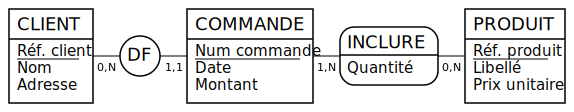

In [ ]:
%%mocodo --title=client_commande_produit --relations=mysql
CLIENT: Réf. client [varchar(8)], Nom [varchar(20)], Adresse [varchar(40)]
DF, 0N CLIENT, 11 COMMANDE
COMMANDE: Num commande [tinyint(4)], Date [date], Montant [decimal(5,2) DEFAULT '0.00']
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité [tinyint(4)]
PRODUIT: Réf. produit [varchar(8)], Libellé [varchar(20)], Prix unitaire [decimal(5,2)]

Quoique ces informations supplémentaires ne soient pas apparues dans le diagramme conceptuel, elles ont été exploitées par la commande, qui a produit dans le répertoire `mocodo_notebook` un fichier directement exécutable par MySQL:

In [ ]:
# %load mocodo_notebook/sandbox_mysql.sql

```sql
CREATE DATABASE IF NOT EXISTS `CLIENT_COMMANDE_PRODUIT` DEFAULT CHARACTER SET utf8 COLLATE utf8_general_ci;
USE `CLIENT_COMMANDE_PRODUIT`;

CREATE TABLE `CLIENT` (
  `réf_client` varchar(8),
  `nom` varchar(20),
  `adresse` varchar(40),
  PRIMARY KEY (`réf_client`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8;

CREATE TABLE `COMMANDE` (
  `num_commande` tinyint(4),
  `date` date,
  `montant` decimal(5,2) DEFAULT '0.00',
  `réf_client` varchar(8),
  PRIMARY KEY (`num_commande`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8;

CREATE TABLE `INCLURE` (
  `num_commande` tinyint(4),
  `réf_produit` varchar(8),
  `quantité` tinyint(4),
  PRIMARY KEY (`num_commande`, `réf_produit`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8;

CREATE TABLE `PRODUIT` (
  `réf_produit` varchar(8),
  `libellé` varchar(20),
  `prix_unitaire` decimal(5,2),
  PRIMARY KEY (`réf_produit`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8;

ALTER TABLE `COMMANDE` ADD FOREIGN KEY (`réf_client`) REFERENCES `CLIENT` (`réf_client`);
ALTER TABLE `INCLURE` ADD FOREIGN KEY (`réf_produit`) REFERENCES `PRODUIT` (`réf_produit`);
ALTER TABLE `INCLURE` ADD FOREIGN KEY (`num_commande`) REFERENCES `COMMANDE` (`num_commande`);
```

**Nouveauté de la version 2.0.17.** Les clefs étrangères composites sont gérées (cf. [issue 14](https://github.com/laowantong/mocodo/issues/14)) et les types manquants remplacés par `VARCHAR(`[`42`](https://fr.wikipedia.org/wiki/La_grande_question_sur_la_vie,_l%27univers_et_le_reste)):

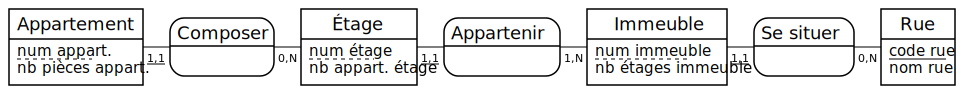

In [ ]:
%%mocodo --title=appartements --relations=sqlite
Appartement: num appart., nb pièces appart.
Composer, 0N Étage, _11 Appartement
Étage: num étage, nb appart. étage
Appartenir, 1N Immeuble, _11 Étage
Immeuble: num immeuble, nb étages immeuble
Se situer, 0N Rue, _11 Immeuble
Rue: code rue, nom rue

In [ ]:
# %load mocodo_notebook/sandbox_sqlite.sql

```sql
.open "APPARTEMENTS";

CREATE TABLE "APPARTEMENT" (
  "code_rue" VARCHAR(42),
  "num_immeuble" VARCHAR(42),
  "num_étage" VARCHAR(42),
  "num_appart" VARCHAR(42),
  "nb_pièces_appart" VARCHAR(42),
  PRIMARY KEY ("code_rue", "num_immeuble", "num_étage", "num_appart"),
  FOREIGN KEY ("code_rue", "num_immeuble", "num_étage") REFERENCES "ÉTAGE" ("code_rue", "num_immeuble", "num_étage")
);

CREATE TABLE "ÉTAGE" (
  "code_rue" VARCHAR(42),
  "num_immeuble" VARCHAR(42),
  "num_étage" VARCHAR(42),
  "nb_appart_étage" VARCHAR(42),
  PRIMARY KEY ("code_rue", "num_immeuble", "num_étage"),
  FOREIGN KEY ("code_rue", "num_immeuble") REFERENCES "IMMEUBLE" ("code_rue", "num_immeuble")
);

CREATE TABLE "IMMEUBLE" (
  "code_rue" VARCHAR(42),
  "num_immeuble" VARCHAR(42),
  "nb_étages_immeuble" VARCHAR(42),
  PRIMARY KEY ("code_rue", "num_immeuble"),
  FOREIGN KEY ("code_rue") REFERENCES "RUE" ("code_rue")
);

CREATE TABLE "RUE" (
  "code_rue" VARCHAR(42),
  "nom_rue" VARCHAR(42),
  PRIMARY KEY ("code_rue")
);
```

#### 6.2.1.5. Dictionnaire des données (bonus) <a id='dictionnaire_des_donnees_bonus'></a>

Qui peut le plus peut le moins: en utilisant un gabarit qui ignore toutes les migrations du passage au relationnel, le même algorithme est capable de construire le dictionnaire des données, à savoir la liste des attributs mis en jeu dans votre MCD, avec leur type ou toute autre annotation placée entre crochets droits après l'attribut.

In [ ]:
%%mocodo --no_mcd --relations=markdown_data_dict
CLIENT: Réf. client [varchar(8)], Nom [varchar(20)], Adresse [varchar(40)]
DF, 0N CLIENT, 11 COMMANDE
COMMANDE: Num commande [tinyint(4)], Date [date], Montant [decimal(5,2) DEFAULT '0.00']
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité [tinyint(4)]
PRODUIT: Réf. produit [varchar(8)], Libellé [varchar(20)], Prix unitaire [decimal(5,2)]

In [ ]:
# %load mocodo_notebook/sandbox_data_dict.md

| Attribut | Informations |
|----------|-------------|
| Réf. client | _varchar(8)_ |
| Nom | _varchar(20)_ |
| Adresse | _varchar(40)_ |
| Num commande | _tinyint(4)_ |
| Date | _date_ |
| Montant | _decimal(5,2) DEFAULT '0.00'_ |
| Quantité | _tinyint(4)_ |
| Réf. produit | _varchar(8)_ |
| Libellé | _varchar(20)_ |
| Prix unitaire | _decimal(5,2)_ |

Si l'une au moins des annotations est omise, la présentation générée sera sensiblement différente:

In [ ]:
%%mocodo --no_mcd --relations=markdown_data_dict
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité [nombre d'unités d'un produit donné dans une commande donnée]
PRODUIT: Réf. produit, Libellé, Prix unitaire

In [ ]:
# %load mocodo_notebook/sandbox_data_dict.md

- Réf. client
- Nom
- Prénom
- Adresse
- Num commande
- Date
- Montant
- Quantité : _nombre d'unités d'un produit donné dans une commande donnée_
- Réf. produit
- Libellé
- Prix unitaire

### 6.2.2. Modification ou création de nouveaux gabarits <a id='modification_ou_creation_de_nouveaux_gabarits'></a>

L'algorithme de génération d'une sortie dans tel ou tel format est totalement découplé de son entrée. Cela signifie que vous pouvez modifier ou créer un format sans écrire une seule ligne de code, mais en remplissant une espèce de formulaire, ou gabarit, qui est un simple fichier JSON. Si vous n'avez aucune velléité de le faire, vous pouvez sauter cette section. Sinon, accrochez-vous, ça va devenir un peu technique.

#### 6.2.2.1. Algorithme <a id='algorithme'></a>

Pour apprendre à spécifier un format, le mieux est d'étudier les gabarits livrés dans le dossier `relation_templates`. Les quelques indications données ici devraient suffire à vous épargner la lecture du code proprement dit.

Chaque gabarit est un fichier JSON associant des clefs prédéfinies à des valeurs librement modifiables. Dans sa forme la plus simple, à savoir le format « texte brut », le fichier (`text.json`) se réduit à trois lignes:

```json
{
  "extension": ".txt"
}
```

La clef `"extension"` est en effet la seule clef obligatoire d'un tel fichier. Ici, elle est associée à la valeur `".txt"`.

Les autres clefs possibles, toutes facultatives, appartiennent à quatre catégories:

| Catégorie | Forme de la clef | Valeur associée | Description |
|--|
| Transformation | `"transform_..."` | objet | Opère une recherche-remplacement, éventuellement itérée (jusqu'à ce qu'aucun remplacement ne soit plus possible), sur une partie du texte déjà généré. Les champs `"search"` et `"replace`" sont obligatoires, le champ `"iterated"` (booléen) est facultatif. La syntaxe est celle des [expressions régulières de Python](https://docs.python.org/2/library/re.html#regular-expression-syntax). |
| Composition | `"compose_..."` | chaîne de format | Interpole dans une chaîne certains identificateurs prédéfinis par une valeur dépendant du contexte en cours. La syntaxe est celle utilisée par la [méthode `.format` de Python](https://docs.python.org/2/library/string.html#format-string-syntax). |
| Concaténation | `"..._separator"` | chaîne | Concatène une liste de chaînes en les séparant par une chaîne donnée. |
| Clef de tri | `"..._sorting_key"` | objet | Extrait la clef de tri pour la liste concernée. L'expression régulière `"search"` contient une ou des parenthèses capturantes qui sont ensuite rappelées dans l'expression `"replace"` |

Voici les différentes opérations effectuées par l'algorithme, dans l'ordre de son déroulement:

1. Toutes les clefs absentes du gabarit sont ajoutées, avec des valeurs par défaut pertinentes.
2. `"transform_attribute"` applique une première transformation à chaque attribut (identificateur `attribute`). Il s'agit en général de supprimer ou remplacer les caractères interdits par le format-cible. Le résultat est référencé par un nouvel identificateur, appelé `"raw_label"`.
3. Différentes capitalisations de ce libellé sont ajoutées sous les noms de `"raw_label_lowercase"` (minuscules),  `"raw_label_uppercase"` (majuscules) et  `"raw_label_titlecase"` (majuscules initiales).
4. `"compose_label_disambiguated_by_annotation"` crée sous le nom de `"label"` une copie de `"raw_label"`, en introduisant en plus dans les clefs étrangères les annotations des pattes correspondantes. La valeur par défaut est `"{raw_label} {leg_annotation}"`, mais pour plus de liberté on peut très bien imaginer de remplacer le label par l'annotation elle-même (avec `"{leg_annotation}"`). Cette composition est optionnelle: pour la désactiver, passer l'option `disambiguation=numbers_only`.
4. <a id='disambiguation_by_number'></a>`"compose_label_disambiguated_by_number"` différencie les libellés homonymes d'une même relation en leur ajoutant un numéro. Par exemple, et c'est la valeur par défaut, pour suffixer le libellé par un point suivi de ce numéro, on écrira: `"{label}.{disambiguation_number}"`. L'identificateur `"label"` est mis à jour avec le résultat. C'est lui que l'utilisateur utilisera en général dans la suite de l'algorithme, mais il a encore accès aux variantes précédentes.
5. Différentes capitalisations de ce libellé sont ajoutées: `"label_lowercase"`, `"label_uppercase"` et  `"label_titlecase"`.
6. `"transform_title"` reçoit le nom du MCD. Le résultat et ses capitalisations sont associés aux identificateurs `"title"`, `"title_lowercase"`, `"title_uppercase"` et  `"title_titlecase"`.
7. Ensuite, pour chacune des relations créées dans la représentation interne:

  1. `"transform_relation_name"` applique une transformation au nom de la relation et l'associe, avec ses capitalisations, aux identificateurs `"this_relation_name"`, `"this_relation_name_lowercase"`, `"this_relation_name_uppercase"` et  `"this_relation_name_titlecase"`.
  2. Le numéro d'ordre de la relation est associé à l'identificateur `"this_relation_number"`.
  3. Pour chaque colonne de la relation en cours:
  
    1. Si l'attribut a migré depuis une entité, le nom de la relation correspondante est associé, avec ses capitalisations, aux identificateurs `"primary_relation_name"`, `"primary_relation_name_lowercase"`, `"primary_relation_name_uppercase"` et  `"primary_relation_name_titlecase"`. Dans le cas contraire, tous ces identificateurs sont associés à la chaîne vide.
    2. Si l'attribut a migré par une association, le nom de celle-ci est associé, avec ses capitalisations, aux identificateurs `"association_name"`, `"association_name_lowercase"`, `"association_name_uppercase"` et  `"association_name_titlecase"`. Dans le cas contraire, tous ces identificateurs sont associés à la chaîne vide.
    3. la composition `"compose_[attribute_nature]"` est appliquée, _cf._ le paragraphe [Composition des attributs selon leur nature](#composition_nature). Le résultat est accumulé dans une liste de colonnes, en deux versions: dans l'ordre de leur énumération, ou triée selon la clef spécifiée dans `"column_sorting_key"`.
  4. `"column_separator"` joint chacune de ces listes de chaînes et associe le résultat à l'identificateur `"columns"` et `"sorted_columns"` (respectivement).
  5. `"compose_relation"` construit une relation complète avec tous ses attributs. Par exemple, et c'est la valeur par défaut, `"{this_relation_name} ({columns})"` est utilisé dans les [formats linéaires](#linear_format).
  6. `"transform_single_column_relation"` s'applique à ce dernier résultat lorsque la relation est réduite à un seul attribut (l'usage est d'en proposer la suppression en la mettant en commentaire).
  7. `"transform_relation"` est appliqué systématiquement, et le résultat est accumulé dans une liste de relations, en deux versions: dans l'ordre de leur énumération, ou triée selon la clef spécifiée dans `"relation_sorting_key"`.
8. `"relation_separator"` joint chacune de ces listes de chaînes et associe le résultat à l'identificateur `"relations"` et `"sorted_relations"` (respectivement).
9. `"compose_relational_schema"` construit un schéma relationnel complet avec son titre et toutes ses relations. La valeur par défaut est simplement `"{relations}"`.
10. `"transform_relational_schema"` applique une dernière transformation au schéma complet, et renvoie le résultat final.

#### 6.2.2.2. Identificateurs disponibles pour la composition de chaînes <a id='identificateurs_disponibles_pour_la_composition_de_chaines'></a>

Mocodo _offline_ est livré avec un gabarit spécialement conçu pour vous aider à en créer de nouveaux. Il vous permet de tester sur n'importe quel MCD la génération d'un objet JSON contenant la valeur de tous les identificateurs disponibles pour la composition au niveau de chaque attribut.

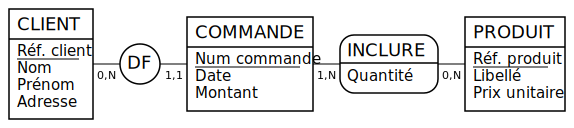

In [ ]:
%%mocodo --title client_commande_produit --relations json
CLIENT: Réf. client, Nom, Prénom, Adresse
DF, 0N CLIENT, 11 COMMANDE
COMMANDE: Num commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

Le contexte d'un attribut donne accès à 32 identificateurs:

- 4 spécifiques à la base;
- 5 spécifiques à la relation;
- 23 spécifiques à l'attribut.

S'y ajoutent `"columns"`, `"sorted_columns"`, et `"relations"`, `"sorted_relations"`, qui n'ont de sens que dans le contexte de `"compose_relation"` et `"compose_relational_schema"`(respectivement).

Le fichier JSON est trop long pour être listé dans son intégralité ici, mais en voici le début, qui concerne la clef primaire _Réf. client_ de la relation _Client_ de la base _client_commande_produit_.

In [ ]:
# %load -r -38 sandbox.json

```json
{
  "title": "client_commande_produit",
  "title_lowercase": "client_commande_produit",
  "title_uppercase": "CLIENT_COMMANDE_PRODUIT",
  "title_titlecase": "Client_commande_produit",
  "relations": [
    {
      "this_relation_name": "CLIENT",
      "this_relation_name_lowercase": "client",
      "this_relation_name_uppercase": "CLIENT",
      "this_relation_name_titlecase": "Client",
      "this_relation_number": 1,
      "columns": [
        {
          "attribute": "Réf. client",
          "raw_label": "Réf. client",
          "raw_label_lowercase": "réf. client",
          "raw_label_uppercase": "RÉF. CLIENT",
          "raw_label_titlecase": "Réf. client",
          "disambiguation_number": null,
          "label": "Réf. client",
          "label_lowercase": "réf. client",
          "label_uppercase": "RÉF. CLIENT",
          "label_titlecase": "Réf. client",
          "primary": true,
          "foreign": false,
          "nature": "primary_key",
          "data_type": null,
          "association_name": null,
          "association_name_lower_case": null,
          "association_name_uppercase": null,
          "association_name_titlecase": null,
          "leg_annotation": null,
          "primary_relation_name": null,
          "primary_relation_name_lowercase": null,
          "primary_relation_name_uppercase": null,
          "primary_relation_name_titlecase": null
        },
```

Ce fragment est à première vue très redondant. En cas de doute, reportez-vous aux tests `relations_tests.py` dans le code-source pour un éventail de cas discriminants.

#### 6.2.2.3. Composition des attributs selon leur nature <a id='composition_nature'></a>

La composition appliquée à un attribut est au cœur de la construction d'une représentation externe. À cette étape, la représentation interne a permis de distinguer 9 catégories d'attributs, 6 courantes et 3 exceptionnelles. Avant de pouvoir exploiter cette classification, il faut la comprendre en détail. Nous allons la présenter à travers deux exemples, le premier répertoriant tous les cas courants, le second tous les cas exceptionnels.

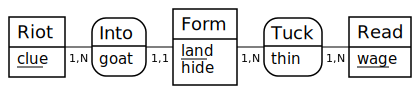

In [ ]:
%%mocodo --mld
Riot: clue
Into, 11 Form, 1N Riot: goat
Form: land, hide
Tuck, 1N Read, 1N Form: thin
Read: wage

| Identificateur | Attribut concerné | Défaut | Exemple | 
|--|--|--|--|
| `compose_primary_key` | identifiant resté sur place lors de la transformation d'une entité en table | `"_{label}_"` | _land_ de **Form** |
| `compose_normal_attribute` | simple attribut resté sur place lors de la transformation d'une entité en table | `"{label}"` | _hide_ de **Form** |
| `compose_foreign_key` | clef étrangère ayant migré par une dépendance fonctionnelle disparue, tout en perdant son caractère identifiant | `"#{label}"` | _clue_ de **Form** |
| `compose_foreign_attribute` | attribut étranger ayant migré d'une dépendance fonctionnelle disparue | même valeur que `compose_normal_attribute` | _goat_ de **Form** |
| `compose_foreign_primary_key` | clef étrangère primaire migré dans une association devenue table, tout en gardant son caractère identifiant  | `"_#{label}_"` | _wage_ et _land_ de **Tuck** |
| `compose_association_attribute` | simple attribut resté sur place lors de la transformation d'une association en table | même valeur que `compose_normal_attribute` | _thin_ de **Tuck** |

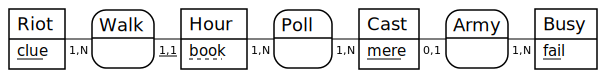

In [ ]:
%%mocodo --mld
Riot: clue
Walk, 1N Riot, _11 Hour
Hour: book
Poll, 1N Cast, 1N /Hour
Cast: mere
Army, 1N /Busy, 01 Cast
Busy: fail

| Identificateur | Attribut concerné | Défaut | Exemple | 
|----------------|-------------------|--------|---------|
| `compose_strengthening_primary_key` | clef primaire de renforcement d'une entité faible | même valeur que `compose_foreign_primary_key` | _clue_ de **Hour** |
| `compose_demoted_foreign_key` | clef étrangère ayant migré dans une association devenue table, mais rétrogradée explicitement au rang de simple attribut | même valeur que `compose_foreign_key` | _book_ de **Poll** |
| `compose_promoting_foreign_key` | clef étrangère non primaire ayant migré dans une dépendance fonctionnelle explicitement promue au rang de table | même valeur que `compose_foreign_key` | _fail_ de **Army** |

#### 6.2.2.4. Gabarit vide <a id='gabarit_vide'></a>

Voici pour référence un gabarit JSON prêt à l'emploi, à partir duquel vous pourrez créer les vôtres. Il comporte l'intégralité des identificateurs disponibles, avec leur valeur par défaut et dans l'ordre de déroulement de l'algorithme:

```
{
    "extension": "requis: pas de valeur par défaut",
    "transform_attribute": [],
    "transform_title": [],
    "transform_data_type": [],
    "compose_label_disambiguated_by_annotation": "{raw_label} {leg_annotation}",
    "compose_label_disambiguated_by_number": "{label}.{disambiguation_number}",
    "compose_primary_key": "_{label}_",
    "compose_normal_attribute": "{label}",
    "compose_foreign_key": "#{label}",
    "compose_foreign_attribute": "par défaut, même valeur que compose_normal_attribute",
    "compose_foreign_primary_key": "_#{label}_",
    "compose_association_attribute": "par défaut, même valeur que compose_normal_attribute",
    "compose_strengthening_primary_key": "par défaut, même valeur que compose_foreign_primary_key",
    "compose_demoted_foreign_key": "par défaut, même valeur que compose_foreign_key",
    "compose_promoting_foreign_key": "par défaut, même valeur que compose_foreign_key",
    "transform_relation_name": [],
    "column_sorting_key": {
        "search": "(.+)",
        "replace": "\\1"
    },
    "column_separator": ", ",
    "compose_relation": "{this_relation_name} ({columns})",
    "transform_single_column_relation": [],
    "transform_relation": [],
    "relation_sorting_key": {
        "search": "(.+)",
        "replace": "\\1"
    },
    "relation_separator": "\n",
    "compose_relational_schema": "{relations}",
    "transform_relational_schema": []
}
```

# 7. Crédits <a id='credits'></a>

- **Auteur**
  - Aristide Grange, Université de Lorraine, Metz, [LCOMS](http://lcoms.univ-lorraine.fr).
- **Outils**
  - Aspect visuel
    - [Color Brewer](http://colorbrewer2.org) (Cynthia Brewer).
    - [Font Awesome](http://fortawesome.github.io/Font-Awesome/) (Dave Gandy).
    - [Fork me on GitHub Retina Ribbons](https://ar.al/scribbles/fork-me-on-github-retina-ribbons/) (Aral Balkan).
    - [Real Favicon Generator](http://realfavicongenerator.net) (Philippe Bernard).
    - [reset.css](http://meyerweb.com/eric/tools/css/reset/) (Eric Meyer).
    - [Source Code Pro](https://github.com/adobe-fonts/source-code-pro) (Paul D. Hunt).
  - JavaScript
    - [JQuery](http://jquery.com/) (John Resig).
    - [JS-Cookie](https://github.com/js-cookie/js-cookie) (Klaus Hartl).
  - Python
    - [Distance de Damerau-Levenshtein](http://mwh.geek.nz/2009/04/26/python-damerau-levenshtein-distance/) (Michael Homer).
- **[Localisation](https://www.transifex.com/aristide/mocodo/)**
  - Allemand: Pascal Fickert, Luis Willnat.
  - Chinois: Liu Jingjiao.
  - Français: Aristide Grange.
- **Sans oublier** 
  Abou-Sophiane Belhadj,
  Kamel Chelghoum,
  Rémi Da Costa,
  Benjamin Gannat,
  Thomas Giro,
  Michel Grandmougin,
  Alexandre Grison,
  David Lorge,
  Dorian Mahut,
  Sébastien Martin,
  Cyril Minette,
  Idris Neumann,
  Bryan Oakley,
  Georges Perec,
  Cédric Poinsaint,
  Zsuzsanna Róka,
  Florian Roméo,
  Tong Ji
  et d'innombrables contributeurs de [Stack Overflow](http://stackoverflow.com).